<a href="https://colab.research.google.com/github/belanatal/PosPUCRio/blob/main/MVP-SprintIIa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

**MVP Sprint II: Machine Learning & Analytics (40530010056_20230_01)**

Aluna: Isabela Fernanda Natal Batista Abreu Gomes

Julho/2023

# **Introdução**

## Programa para obtenção, tratamento e análise do histórico de Energia Natural Afluente (ENA), da Energia Armazenada (EArm), da Demanda/Carga e do Custo Marginal da Operação (CMO) por subsistema, a partir da área de Dados Abertos do Operador Nacional do Sistema Elétrico (ONS): [Arquitetura Aberta](https://dados.ons.org.br/)

> Bloco com recuo




> No Brasil, a projeção de preços da energia elétrica baseia-se na previsão, centralizada, de despacho das usinas pelo Operador Nacional do Sistema Elétrico (ONS).

> Em linhas gerais, o preço da energia, também chamado de Preço de Liquidação das Diferenças (PLD) tem como base o Custo Marginal da Operação (CMO), dado pelo planejamento da operação hidrotérmica do Sistema Interligado Nacional. Os modelos utilizados para projeção oficial do despacho das usinas pelo ONS (Operador Nacional do Sistema) denominam-se NEWAVE, DECOMP e DESSEM, todos desenvolvidos e fornecidos pelo Centro de Pesquisas da Eletrobras (CEPEL), conforme ilustrado na Figura 1.

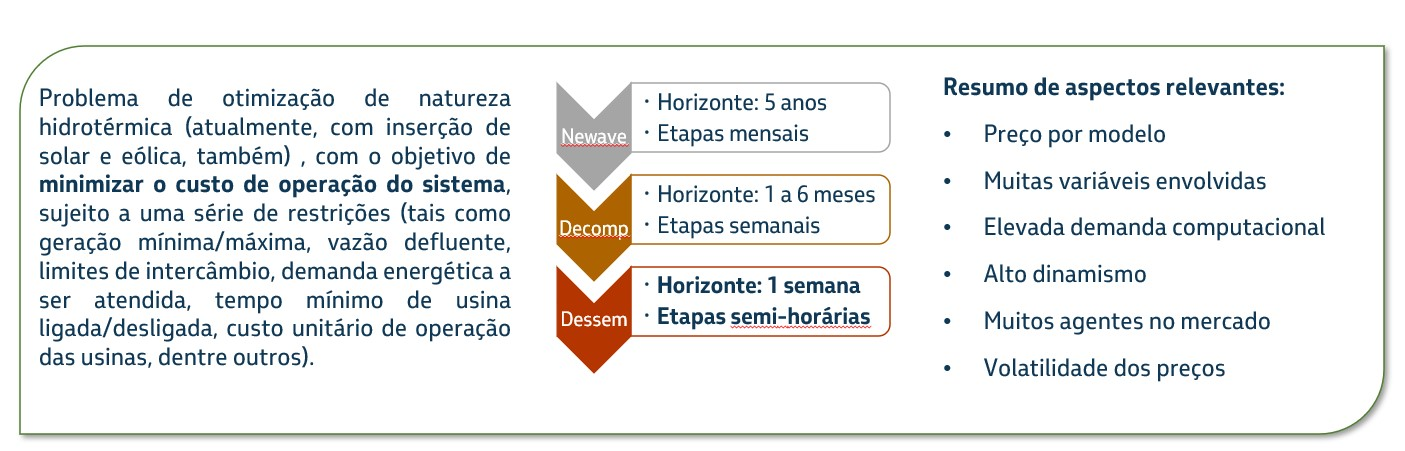

Figura 1 - Resumo do problema de planejamento eletroenergético brasileiro.

> Para a projeção do preço da energia elétrica, uma série de grandezas são utilizadas como entrada. Uma vez que a matriz eletroenergética brasileira é predominantemente hidráulica (e os modelos consideram este aspecto no equacionamento do problema de otimização), a diferença entre as vazões previstas e verificadas dos postos associados às usinas hidroelétricas responde por cerca de 50% das variações no PLD/CMO, conforme ilustrado na Figura 2, disponibilizada pela Câmara de Comercialização de Energia (CCEE). A Energia Armazenada e a Carga também desempenham papel relevante na influência do PLD/CMO. Juntas, as três grandezas respondem por mais de 70% das variações no custo marginal da operação sendo, portanto, as variáveis de interesse na primeira abordagem deste MVP.

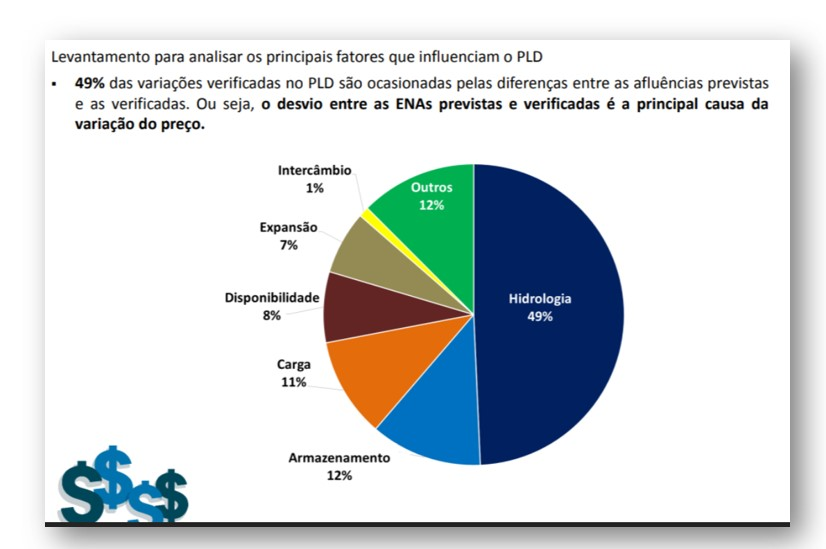

Figura 2 - Variação do PLD/CMO por variável de entrada nos modelos de planejamento eletroenergético do SIN. Fonte: CCEE


> Neste contexto, considerando a atuação na área de Inteligência de Mercado de Gás e Energia em um dos principais agentes geradores do Brasil, faz sentido estruturarmos a coleta e tratamento dos dados referentes às grandezas mencionadas, visando à melhor tomada de decisão sob a ótica da operação do parque e da comercialização e logística do gás e da energia elétrica.





# **Seção I: Obtenção e Tratamento Inicial dos Dados**


1.   [Energia Natural Afluente (ENA) por Subsistema](https://dados.ons.org.br/dataset/ena-diario-por-subsistema)
2.   [Energia Armazenada (EArm) por Subsistema](https://dados.ons.org.br/dataset/ear-diario-por-subsistema)
3.   [Demanda por Subsistema](https://dados.ons.org.br/dataset/carga-energia)
4.   [Custo Marginal da Operação (CMO) Semanal por Subsistema](https://dados.ons.org.br/dataset/cmo-semanal)





> Diariamente, o Operador Nacional do Sistema Elétrico disponibiliza os dados verificados das grandezas supracitadas, para cada um dos 4 subsistemas (Sudeste, Sul, Nordeste e Norte) que compõem eletroenergeticamente o Sistema Interligado Nacional. Para atender ao presente trabalho, estes dados serão tratados, manipulados, pré-processados e avaliados de modo que, em etapas futuras, seja possível aplicar técnicas e algoritmos de Machine Learning a eles, com o objetivo de tentar realizar predições e análises de sensibilidade de Custos Marginais da Operação futuros, por fora dos modelos oficiais.

> Trata-se, portanto, de um problema de Aprendizado Supervisionado, considerando as principais grandezas envolvidas no cálculo do CMO, segundo a Câmara de Comercialização de Energia.



Inicialmente, iremos importar e avaliar (utilizando a biblioteca Pandas, para fazer uma rápida análise exploratória) os dataset de "entrada", variáveis explicativas para a obtenção do CMO: ENA, EArm e Demanda, nesta ordem.

In [ ]:
# Primeiro bloco: Importação das bibliotecas e módulos
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")
#
# Importando as bibliotecas pandas, matplotlib (pyplot), seaborn e datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
#
## Transformações Numéricas e ML
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import GridSearchCV # para tuning dos hiperparâmetros dos estimadores
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import LogisticRegression # algoritmo Regressão Logística
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM
#
## Para aplicação de métodos ensemble em ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor #Histogram-Based Gradient Boosting: de acordo com a biblioteca do scikitlearn, mais rápido que o GradientBoostingRegressor
from sklearn.datasets import make_friedman1
#
## Transformações Categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

## Energia Natural Afluente: ENA

***ENA DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia natural afluente (ENA) dos reservatórios com periodicidade diária por Subsistemas.

A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [ ]:
# Seção I.1: Programa para obtenção das Energias Naturais Afluentes - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.
# ENA - Arquivos com os dados anuais, com histórico desde 2001
ano_zero=2001
ano_inicio=ano_zero+1
data_fim=datetime.datetime.now() - datetime.timedelta(days=5) #ano vigente, considerando um possível atraso de até 5 dias na publicação, o que é comum na virada de ano
ano_fim=data_fim.strftime("%Y")
ano_fim=int(ano_fim)
print(data_fim)
print(ano_fim)

2023-07-13 13:55:41.990424
2023


In [ ]:
#Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
#Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ena=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
ena=pd.DataFrame(ena)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    ena_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    ena_ano=pd.DataFrame(ena_ano)
    ena=pd.concat([ena,ena_ano])
print(ena)

    id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0               N          NORTE  2001-01-01            10154.000000   
1              NE       NORDESTE  2001-01-01            13472.000000   
2               S            SUL  2001-01-01             7703.000000   
3              SE        SUDESTE  2001-01-01            39186.000000   
4               N          NORTE  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
783            SE        SUDESTE  2023-07-15            23490.164062   
784             N          NORTE  2023-07-16             4114.634766   
785            NE       NORDESTE  2023-07-16             2074.394043   
786             S            SUL  2023-07-16            28962.023438   
787            SE        SUDESTE  2023-07-16            23074.888672   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [ ]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
ena.head(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0             N          NORTE  2001-01-01                 10154.0   
1            NE       NORDESTE  2001-01-01                 13472.0   
2             S            SUL  2001-01-01                  7703.0   
3            SE        SUDESTE  2001-01-01                 39186.0   
4             N          NORTE  2001-01-02                  9590.0   
5            NE       NORDESTE  2001-01-02                 13551.0   
6             S            SUL  2001-01-02                  6730.0   
7            SE        SUDESTE  2001-01-02                 41230.0   
8             N          NORTE  2001-01-03                  9066.0   
9            NE       NORDESTE  2001-01-03                 13551.0   

   ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                      122.339996                        9033.0   
1                      101.480003                       13385.0   
2                      160.910004                        7703.0   
3                       86.980003                       37611.0   
4                      115.550003                        8091.0   
5                      102.080002                       13465.0   
6                      140.580002                        6730.0   
7                       91.519997                       40063.0   
8                      109.239998                        7213.0   
9                      102.080002                       13461.0   

   ena_armazenavel_regiao_percentualmlt  
0                            108.839996  
1                            100.830002  
2                            160.910004  
3                             83.489998  
4                             97.489998  
5                            101.430000  
6                            140.580002  
7                             88.930000  
8                             86.910004  
9                            101.400002

In [ ]:
# Conferindo as últimas 10 linhas
ena.tail(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
778             S            SUL  2023-07-14            46205.621094   
779            SE        SUDESTE  2023-07-14            23547.382812   
780             N          NORTE  2023-07-15             4052.500977   
781            NE       NORDESTE  2023-07-15             2090.446045   
782             S            SUL  2023-07-15            36728.191406   
783            SE        SUDESTE  2023-07-15            23490.164062   
784             N          NORTE  2023-07-16             4114.634766   
785            NE       NORDESTE  2023-07-16             2074.394043   
786             S            SUL  2023-07-16            28962.023438   
787            SE        SUDESTE  2023-07-16            23074.888672   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
778                      422.592407                  21595.277344   
779                       91.821503                  23431.486328   
780                       77.032204                   3892.724121   
781                       55.375702                   2053.791992   
782                      335.912689                  15880.938477   
783                       91.598396                  22991.978516   
784                       78.213303                   4001.548096   
785                       55.687500                   2051.513916   
786                      264.884003                   9244.137695   
787                       89.978996                  22561.486328   

     ena_armazenavel_regiao_percentualmlt  
778                            197.508408  
779                             91.369598  
780                             73.995102  
781                             54.404701  
782                            145.245605  
783                             89.655701  
784                             76.063698  
785                             55.073299  
786                             84.545998  
787                             87.976997

In [ ]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(ena)/4

8232.0

In [ ]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                            object
nom_subsistema                           object
ena_data                                 object
ena_bruta_regiao_mwmed                  float64
ena_bruta_regiao_percentualmlt          float64
ena_armazenavel_regiao_mwmed            float64
ena_armazenavel_regiao_percentualmlt    float64
dtype: object

In [ ]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
ena['nom_subsistema']=ena['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [ ]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
ena=ena.rename(columns = {'ena_data':'Data'})
print(ena)

    id_subsistema nom_subsistema        Data  ena_bruta_regiao_mwmed  \
0               N          Norte  2001-01-01            10154.000000   
1              NE       Nordeste  2001-01-01            13472.000000   
2               S            Sul  2001-01-01             7703.000000   
3              SE        Sudeste  2001-01-01            39186.000000   
4               N          Norte  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
783            SE        Sudeste  2023-07-15            23490.164062   
784             N          Norte  2023-07-16             4114.634766   
785            NE       Nordeste  2023-07-16             2074.394043   
786             S            Sul  2023-07-16            28962.023438   
787            SE        Sudeste  2023-07-16            23074.888672   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [ ]:
# Alterando o tipo da coluna "Data"
ena['Data'] = pd.to_datetime(ena['Data'])

In [ ]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                                   object
nom_subsistema                                  object
Data                                    datetime64[ns]
ena_bruta_regiao_mwmed                         float64
ena_bruta_regiao_percentualmlt                 float64
ena_armazenavel_regiao_mwmed                   float64
ena_armazenavel_regiao_percentualmlt           float64
dtype: object

In [ ]:
# Reordenando o dataframe ena, pela coluna Data (em ordem decrescente)
ena=ena.sort_values(by='Data', ascending=False)
ena.head(20)

id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
787            SE        Sudeste 2023-07-16            23074.888672   
786             S            Sul 2023-07-16            28962.023438   
785            NE       Nordeste 2023-07-16             2074.394043   
784             N          Norte 2023-07-16             4114.634766   
783            SE        Sudeste 2023-07-15            23490.164062   
782             S            Sul 2023-07-15            36728.191406   
781            NE       Nordeste 2023-07-15             2090.446045   
780             N          Norte 2023-07-15             4052.500977   
777            NE       Nordeste 2023-07-14             2101.937988   
776             N          Norte 2023-07-14             4066.364990   
779            SE        Sudeste 2023-07-14            23547.382812   
778             S            Sul 2023-07-14            46205.621094   
775            SE        Sudeste 2023-07-13            22856.339844   
774             S            Sul 2023-07-13            52300.542969   
773            NE       Nordeste 2023-07-13             2105.249023   
772             N          Norte 2023-07-13             4023.511963   
769            NE       Nordeste 2023-07-12             2103.698975   
768             N          Norte 2023-07-12             4228.970215   
771            SE        Sudeste 2023-07-12            23746.201172   
770             S            Sul 2023-07-12            38335.539062   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
787                       89.978996                  22561.486328   
786                      264.884003                   9244.137695   
785                       55.687500                   2051.513916   
784                       78.213303                   4001.548096   
783                       91.598396                  22991.978516   
782                      335.912689                  15880.938477   
781                       55.375702                   2053.791992   
780                       77.032204                   3892.724121   
777                       55.680099                   2101.937988   
776                       77.295700                   3886.738037   
779                       91.821503                  23431.486328   
778                      422.592407                  21595.277344   
775                       89.126801                  22574.703125   
774                      478.335999                  10606.338867   
773                       55.767799                   2085.944092   
772                       76.481201                   3903.990967   
769                       55.726700                   2092.974121   
768                       80.386597                   4086.571045   
771                       92.596802                  23328.566406   
770                      350.613312                   7774.855957   

     ena_armazenavel_regiao_percentualmlt  
787                             87.976997  
786                             84.545998  
785                             55.073299  
784                             76.063698  
783                             89.655701  
782                            145.245605  
781                             54.404701  
780                             73.995102  
777                             55.680099  
776                             73.881302  
779                             91.369598  
778                            197.508408  
775                             88.028603  
774                             97.004601  
773                             55.256401  
772                             74.209198  
769                             55.442600  
768                             77.679802  
771                             90.968201  
770                             71.108101

## Energia Armazenada: EArm

***EAR DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia armazenada (EAR) em periodicidade diária por Subsistemas.

A Energia Armazenada (EAR) representa a energia associada ao volume de água disponível nos reservatórios que pode ser convertido em geração na própria usina e em todas as usinas à jusante na cascata. A grandeza de EAR leva em conta nível verificado nos reservatórios na data de referência. A grandeza de EAR máxima representa a capacidade de armazenamento caso todos os reservatórios do sistema estivessem cheios. A grandeza de EAR para o subsistema à jusante considera a utilização da água do reservatório para produzir energia em uma usina à jusante que está em um subsistema diferente.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [ ]:
# Seção I.2: Programa para obtenção das Energias Armazenadas - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# EArm - Arquivos com os dados anuais, com histórico desde 2001.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
earm=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
earm=pd.DataFrame(earm)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    earm_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    earm_ano=pd.DataFrame(earm_ano)
    earm=pd.concat([earm,earm_ano])
print (earm)

    id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0              NE       NORDESTE  2001-01-01        49967.000000   
1               N          NORTE  2001-01-01        12311.000000   
2              SE        SUDESTE  2001-01-01       159081.000000   
3               S            SUL  2001-01-01        14176.000000   
4              NE       NORDESTE  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
783             S            SUL  2023-07-15        20459.242188   
784            NE       NORDESTE  2023-07-16        51691.226562   
785             N          NORTE  2023-07-16        15302.396484   
786            SE        SUDESTE  2023-07-16       204615.328125   
787             S            SUL  2023-07-16        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [ ]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
earm.head(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0            NE       NORDESTE  2001-01-01             49967.0   
1             N          NORTE  2001-01-01             12311.0   
2            SE        SUDESTE  2001-01-01            159081.0   
3             S            SUL  2001-01-01             14176.0   
4            NE       NORDESTE  2001-01-02             49967.0   
5             N          NORTE  2001-01-02             12311.0   
6            SE        SUDESTE  2001-01-02            159081.0   
7             S            SUL  2001-01-02             14176.0   
8            NE       NORDESTE  2001-01-03             49967.0   
9             N          NORTE  2001-01-03             12311.0   

   ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                     18699.0                        37.419998  
1                      9137.0                        74.220001  
2                     46315.0                        29.110001  
3                     12857.0                        90.690002  
4                     18851.0                        37.730000  
5                      9327.0                        75.760002  
6                     46850.0                        29.450001  
7                     12920.0                        91.139999  
8                     19047.0                        38.119999  
9                      9453.0                        76.779999

In [ ]:
# Conferindo as últimas 10 linhas
earm.tail(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
778            SE        SUDESTE  2023-07-14       204615.328125   
779             S            SUL  2023-07-14        20459.242188   
780            NE       NORDESTE  2023-07-15        51691.226562   
781             N          NORTE  2023-07-15        15302.396484   
782            SE        SUDESTE  2023-07-15       204615.328125   
783             S            SUL  2023-07-15        20459.242188   
784            NE       NORDESTE  2023-07-16        51691.226562   
785             N          NORTE  2023-07-16        15302.396484   
786            SE        SUDESTE  2023-07-16       204615.328125   
787             S            SUL  2023-07-16        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
778               174926.765625                        85.490501  
779                18638.333984                        91.099800  
780                42241.425781                        81.718803  
781                14537.874023                        95.003899  
782               174920.859375                        85.487701  
783                18691.025391                        91.357399  
784                42159.089844                        81.559502  
785                14527.134766                        94.933701  
786               174824.625000                        85.440598  
787                18722.396484                        91.510696

In [ ]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(earm)/4

8232.0

In [ ]:
# Verificando os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                       object
nom_subsistema                      object
ear_data                            object
ear_max_subsistema                 float64
ear_verif_subsistema_mwmes         float64
ear_verif_subsistema_percentual    float64
dtype: object

In [ ]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
earm['nom_subsistema']=earm['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [ ]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
earm=earm.rename(columns = {'ear_data':'Data'})
print(earm)

    id_subsistema nom_subsistema        Data  ear_max_subsistema  \
0              NE       Nordeste  2001-01-01        49967.000000   
1               N          Norte  2001-01-01        12311.000000   
2              SE        Sudeste  2001-01-01       159081.000000   
3               S            Sul  2001-01-01        14176.000000   
4              NE       Nordeste  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
783             S            Sul  2023-07-15        20459.242188   
784            NE       Nordeste  2023-07-16        51691.226562   
785             N          Norte  2023-07-16        15302.396484   
786            SE        Sudeste  2023-07-16       204615.328125   
787             S            Sul  2023-07-16        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [ ]:
# Alterando o tipo da coluna "Data"
earm['Data'] = pd.to_datetime(earm['Data'])

In [ ]:
# Verificando novamente os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                              object
nom_subsistema                             object
Data                               datetime64[ns]
ear_max_subsistema                        float64
ear_verif_subsistema_mwmes                float64
ear_verif_subsistema_percentual           float64
dtype: object

In [ ]:
# Reordenando o dataframe earm, pela coluna Data (em ordem decrescente)
earm=earm.sort_values(by='Data', ascending=False)
earm.head(20)

id_subsistema nom_subsistema       Data  ear_max_subsistema  \
787             S            Sul 2023-07-16        20459.242188   
786            SE        Sudeste 2023-07-16       204615.328125   
785             N          Norte 2023-07-16        15302.396484   
784            NE       Nordeste 2023-07-16        51691.226562   
783             S            Sul 2023-07-15        20459.242188   
782            SE        Sudeste 2023-07-15       204615.328125   
781             N          Norte 2023-07-15        15302.396484   
780            NE       Nordeste 2023-07-15        51691.226562   
777             N          Norte 2023-07-14        15302.396484   
776            NE       Nordeste 2023-07-14        51691.226562   
779             S            Sul 2023-07-14        20459.242188   
778            SE        Sudeste 2023-07-14       204615.328125   
775             S            Sul 2023-07-13        20459.242188   
774            SE        Sudeste 2023-07-13       204615.328125   
773             N          Norte 2023-07-13        15302.396484   
772            NE       Nordeste 2023-07-13        51691.226562   
769             N          Norte 2023-07-12        15302.396484   
768            NE       Nordeste 2023-07-12        51691.226562   
771             S            Sul 2023-07-12        20459.242188   
770            SE        Sudeste 2023-07-12       204615.328125   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
787                18722.396484                        91.510696  
786               174824.625000                        85.440598  
785                14527.134766                        94.933701  
784                42159.089844                        81.559502  
783                18691.025391                        91.357399  
782               174920.859375                        85.487701  
781                14537.874023                        95.003899  
780                42241.425781                        81.718803  
777                14546.465820                        95.060097  
776                42367.031250                        81.961700  
779                18638.333984                        91.099800  
778               174926.765625                        85.490501  
775                18534.923828                        90.594398  
774               175029.187500                        85.540604  
773                14577.816406                        95.264900  
772                42505.894531                        82.230400  
769                14627.884766                        95.592102  
768                42650.933594                        82.511002  
771                18440.337891                        90.132103  
770               175294.734375                        85.670403

## Carga (Demanda) Eletroenergética

***CARGA DE ENERGIA DIÁRIA*** (Segundo o ONS)

Dados de carga por subsistema em base diária, medida em MWmed.

Até fevereiro/2021, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS. Entre março/2021 e abril/23, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS, mais a previsão de geração de usinas não despachadas pelo ONS. A partir de 29/04/2023, além dos dados anteriormente considerados, passou a ser incorporado o valor estimado da micro e minigeração distribuída (MMGD), com base em dados meteorológicos previstos.

In [ ]:
# Seção I.3: Programa para obtenção da Carga Elétrica - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# Carga - Arquivos com os dados anuais, com histórico desde 2001.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
carga=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
carga=pd.DataFrame(carga)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    carga_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    carga_ano=pd.DataFrame(carga_ano)
    carga=pd.concat([carga,carga_ano])
print(carga)

    id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0               N                 Norte   2001-01-01            2376.731250
1              NE              Nordeste   2001-01-01            5035.816667
2               S                   Sul   2001-01-01            4925.373750
3              SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4               N                 Norte   2001-01-02            2537.383333
..            ...                   ...          ...                    ...
783            SE  Sudeste/Centro-Oeste   2023-07-15           35918.580917
784             N                 Norte   2023-07-16            6787.679792
785            NE              Nordeste   2023-07-16           10689.597292
786             S                   Sul   2023-07-16            8588.719583
787            SE  Sudeste/Centro-Oeste   2023-07-16           33531.759500

[32929 rows x 4 columns]


In [ ]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
carga.head(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0             N                 Norte   2001-01-01            2376.731250
1            NE              Nordeste   2001-01-01            5035.816667
2             S                   Sul   2001-01-01            4925.373750
3            SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4             N                 Norte   2001-01-02            2537.383333
5            NE              Nordeste   2001-01-02            5946.387500
6             S                   Sul   2001-01-02            6779.687500
7            SE  Sudeste/Centro-Oeste   2001-01-02           24596.195417
8             N                 Norte   2001-01-03            2540.345833
9            NE              Nordeste   2001-01-03            6188.104167

In [ ]:
# Conferindo as últimas 10 linhas
carga.tail(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
778             S                   Sul   2023-07-14           11964.354500
779            SE  Sudeste/Centro-Oeste   2023-07-14           39799.319708
780             N                 Norte   2023-07-15            7070.928375
781            NE              Nordeste   2023-07-15           11621.188167
782             S                   Sul   2023-07-15           10013.116333
783            SE  Sudeste/Centro-Oeste   2023-07-15           35918.580917
784             N                 Norte   2023-07-16            6787.679792
785            NE              Nordeste   2023-07-16           10689.597292
786             S                   Sul   2023-07-16            8588.719583
787            SE  Sudeste/Centro-Oeste   2023-07-16           33531.759500

In [ ]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(carga)/4

8232.25

In [ ]:
carga_null=(carga['val_cargaenergiamwmed'].isnull() == True)
carganull=carga.loc[carga_null]
print(carganull)

     id_subsistema        nom_subsistema         din_instante  \
132              S                   Sul  2013-02-02 00:00:01   
1337             N                 Norte  2013-12-01 00:00:00   
1338            NE              Nordeste  2013-12-01 00:00:00   
1339             S                   Sul  2013-12-01 00:00:00   
1340            SE  Sudeste/Centro-Oeste  2013-12-01 00:00:00   
124              N                 Norte           2014-02-01   
125             NE              Nordeste           2014-02-01   
126              S                   Sul           2014-02-01   
127             SE  Sudeste/Centro-Oeste           2014-02-01   
392              N                 Norte           2015-04-09   
393             NE              Nordeste           2015-04-09   
394              S                   Sul           2015-04-09   
395             SE  Sudeste/Centro-Oeste           2015-04-09   
380              N                 Norte           2016-04-05   
381             NE       

Constata-se, pela quantidade de dias, que o dataframe "carga" tem uma linha a mais que os dataframes "ena" e "earm". Ao mesclarmos as consultas, desejaremos excluir essa linha a mais.

In [ ]:
# Verificando os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema             object
nom_subsistema            object
din_instante              object
val_cargaenergiamwmed    float64
dtype: object

In [ ]:
# Iniciando o tratamento dos dados
# Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
carga['nom_subsistema']=carga['nom_subsistema'].replace({'Sudeste/Centro-Oeste':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [ ]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
carga=carga.rename(columns = {'din_instante':'Data'})
print(carga)

    id_subsistema nom_subsistema        Data  val_cargaenergiamwmed
0               N          Norte  2001-01-01            2376.731250
1              NE       Nordeste  2001-01-01            5035.816667
2               S            Sul  2001-01-01            4925.373750
3              SE        Sudeste  2001-01-01           19729.233333
4               N          Norte  2001-01-02            2537.383333
..            ...            ...         ...                    ...
783            SE        Sudeste  2023-07-15           35918.580917
784             N          Norte  2023-07-16            6787.679792
785            NE       Nordeste  2023-07-16           10689.597292
786             S            Sul  2023-07-16            8588.719583
787            SE        Sudeste  2023-07-16           33531.759500

[32929 rows x 4 columns]


In [ ]:
# Alterando o tipo da coluna "Data"
carga['Data'] = pd.to_datetime(carga['Data'])

In [ ]:
# Verificando novamente os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema                    object
nom_subsistema                   object
Data                     datetime64[ns]
val_cargaenergiamwmed           float64
dtype: object

In [ ]:
# Reordenando o dataframe carga, pela coluna Data (em ordem decrescente)
carga=carga.sort_values(by='Data', ascending=False)
carga.head(20)

id_subsistema nom_subsistema       Data  val_cargaenergiamwmed
787            SE        Sudeste 2023-07-16           33531.759500
786             S            Sul 2023-07-16            8588.719583
785            NE       Nordeste 2023-07-16           10689.597292
784             N          Norte 2023-07-16            6787.679792
783            SE        Sudeste 2023-07-15           35918.580917
782             S            Sul 2023-07-15           10013.116333
781            NE       Nordeste 2023-07-15           11621.188167
780             N          Norte 2023-07-15            7070.928375
777            NE       Nordeste 2023-07-14           12017.207958
776             N          Norte 2023-07-14            7354.199292
779            SE        Sudeste 2023-07-14           39799.319708
778             S            Sul 2023-07-14           11964.354500
775            SE        Sudeste 2023-07-13           41440.380458
774             S            Sul 2023-07-13           12162.456542
773            NE       Nordeste 2023-07-13           11926.319833
772             N          Norte 2023-07-13            7362.410500
769            NE       Nordeste 2023-07-12           12041.721708
768             N          Norte 2023-07-12            7358.439458
771            SE        Sudeste 2023-07-12           41627.172958
770             S            Sul 2023-07-12           12879.681042

## Custo Marginal da Operação (CMO)

***CUSTO MARGINAL DA OPERAÇÃO*** (Segundo o ONS)

Valores do custo, por unidade de energia produzida, para atender ao incremento de uma unidade de carga no SIN, chamado de Custo Marginal de Operação – CMO. Valores para cada semana operativa por subsistema, e por patamar de carga, além da média semanal, estimados pelo modelo Decomp.

> Considerações sobre o Custo Marginal da Operação: Até 2020, o cálculo do CMO era realizado por patamar de carga (pesada, média ou leve): um único valor para cada patamar dentro da semana operativa (iniciada no sábado até a sexta-feira seguinte).  A distribuição das horas pelos patamares de carga varia de acordo com o dia da semana (se é útil ou não) e com o mês (se verão, inverno ou "intermediário"). A partir de 2020, o CMO passou a ser calculado com granularidade horária. No entanto, considerando o histórico dos últimos 3 anos, poucas foram as vezes em que houve um descolamento significativo entre o custo horário e o custo semanal. Por este motivo, para este trabalho (e para as etapas futuras), será considerado o CMO semanal, para todo o horizonte disponível.




In [ ]:
# Seção I.4: Programa para obtenção do Custo Marginal da Operação - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# CMO - Arquivos com os dados anuais, com histórico desde 2005.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas), à exceção do ano zero/de início
# Ao contrário das demais grandezas, os valores de CMO ora importados são semanais, vigorando do sábado à sexta-feira da semana operativa.
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ano_zerocmo=2005
ano_iniciocmo=ano_zerocmo+1
cmo=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+str(ano_zerocmo)+".csv", delimiter=";",encoding = 'utf8')
cmo=pd.DataFrame(cmo)
for ano in range (ano_iniciocmo,ano_fim+1):
    ano_str=str(ano)
    cmo_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+ano_str+".csv", delimiter=";", encoding = 'utf8')
    cmo_ano=pd.DataFrame(cmo_ano)
    cmo=pd.concat([cmo,cmo_ano])
print(cmo)

    id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
0               N          NORTE   2005-01-07                 0.94   
1              NE       NORDESTE   2005-01-07                 0.94   
2               S            SUL   2005-01-07                 4.50   
3              SE        SUDESTE   2005-01-07                 0.00   
4               N          NORTE   2005-01-14                 6.34   
..            ...            ...          ...                  ...   
111            SE        SUDESTE   2023-07-14                 0.00   
112             N          NORTE   2023-07-21                 0.00   
113            NE       NORDESTE   2023-07-21                 0.00   
114             S            SUL   2023-07-21                 0.00   
115            SE        SUDESTE   2023-07-21                 0.00   

     val_cmoleve  val_cmomedia  val_cmopesada  
0           0.94          0.94           0.94  
1           0.94          0.94           0.94  
2           4.3

In [ ]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
cmo.head(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  val_cmoleve  \
0             N          NORTE   2005-01-07                 0.94         0.94   
1            NE       NORDESTE   2005-01-07                 0.94         0.94   
2             S            SUL   2005-01-07                 4.50         4.39   
3            SE        SUDESTE   2005-01-07                 0.00         0.00   
4             N          NORTE   2005-01-14                 6.34         5.87   
5            NE       NORDESTE   2005-01-14                 7.64         7.64   
6             S            SUL   2005-01-14                12.32        12.11   
7            SE        SUDESTE   2005-01-14                 6.34         5.87   
8             N          NORTE   2005-01-21                 0.82         0.83   
9            NE       NORDESTE   2005-01-21                 0.69         0.69   

   val_cmomedia  val_cmopesada  
0          0.94           0.94  
1          0.94           0.94  
2          4.59           4.59  
3          0.00           0.00  
4          6.41           7.64  
5          7.64           7.64  
6         12.44          12.44  
7          6.41           7.64  
8          0.79           0.93  
9          0.69           0.69

In [ ]:
# Conferindo as últimas 10 linhas
cmo.tail(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
106             S            SUL   2023-07-07                  0.0   
107            SE        SUDESTE   2023-07-07                  0.0   
108             N          NORTE   2023-07-14                  0.0   
109            NE       NORDESTE   2023-07-14                  0.0   
110             S            SUL   2023-07-14                  0.0   
111            SE        SUDESTE   2023-07-14                  0.0   
112             N          NORTE   2023-07-21                  0.0   
113            NE       NORDESTE   2023-07-21                  0.0   
114             S            SUL   2023-07-21                  0.0   
115            SE        SUDESTE   2023-07-21                  0.0   

     val_cmoleve  val_cmomedia  val_cmopesada  
106          0.0           0.0            0.0  
107          0.0           0.0            0.0  
108          0.0           0.0            0.0  
109          0.0           0.0            0.0  
110          0.0           0.0            0.0  
111          0.0           0.0            0.0  
112          0.0           0.0            0.0  
113          0.0           0.0            0.0  
114          0.0           0.0            0.0  
115          0.0           0.0            0.0

In [ ]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
cmo['nom_subsistema']=cmo['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [ ]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
cmo=cmo.rename(columns = {'din_instante':'Data'})
print(cmo)

    id_subsistema nom_subsistema        Data  val_cmomediasemanal  \
0               N          Norte  2005-01-07                 0.94   
1              NE       Nordeste  2005-01-07                 0.94   
2               S            Sul  2005-01-07                 4.50   
3              SE        Sudeste  2005-01-07                 0.00   
4               N          Norte  2005-01-14                 6.34   
..            ...            ...         ...                  ...   
111            SE        Sudeste  2023-07-14                 0.00   
112             N          Norte  2023-07-21                 0.00   
113            NE       Nordeste  2023-07-21                 0.00   
114             S            Sul  2023-07-21                 0.00   
115            SE        Sudeste  2023-07-21                 0.00   

     val_cmoleve  val_cmomedia  val_cmopesada  
0           0.94          0.94           0.94  
1           0.94          0.94           0.94  
2           4.39          4

In [ ]:
# Verificando novamente os tipos de coluna do dataframe cmo
cmo.dtypes

id_subsistema           object
nom_subsistema          object
Data                    object
val_cmomediasemanal    float64
val_cmoleve            float64
val_cmomedia           float64
val_cmopesada          float64
dtype: object

In [ ]:
# Alterando o tipo da coluna "Data"
cmo['Data'] = pd.to_datetime(cmo['Data'])

In [ ]:
# Reordenando o dataframe cmo, pela coluna Data (em ordem decrescente)
cmo=cmo.sort_values(by='Data', ascending=False)
cmo.head(20)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
115            SE        Sudeste 2023-07-21                  0.0          0.0   
114             S            Sul 2023-07-21                  0.0          0.0   
113            NE       Nordeste 2023-07-21                  0.0          0.0   
112             N          Norte 2023-07-21                  0.0          0.0   
111            SE        Sudeste 2023-07-14                  0.0          0.0   
110             S            Sul 2023-07-14                  0.0          0.0   
109            NE       Nordeste 2023-07-14                  0.0          0.0   
108             N          Norte 2023-07-14                  0.0          0.0   
107            SE        Sudeste 2023-07-07                  0.0          0.0   
106             S            Sul 2023-07-07                  0.0          0.0   
105            NE       Nordeste 2023-07-07                  0.0          0.0   
104             N          Norte 2023-07-07                  0.0          0.0   
102             S            Sul 2023-06-30                  0.0          0.0   
100             N          Norte 2023-06-30                  0.0          0.0   
101            NE       Nordeste 2023-06-30                  0.0          0.0   
103            SE        Sudeste 2023-06-30                  0.0          0.0   
99             SE        Sudeste 2023-06-23                  0.0          0.0   
98              S            Sul 2023-06-23                  0.0          0.0   
97             NE       Nordeste 2023-06-23                  0.0          0.0   
96              N          Norte 2023-06-23                  0.0          0.0   

     val_cmomedia  val_cmopesada  
115           0.0            0.0  
114           0.0            0.0  
113           0.0            0.0  
112           0.0            0.0  
111           0.0            0.0  
110           0.0            0.0  
109           0.0            0.0  
108           0.0            0.0  
107           0.0            0.0  
106           0.0            0.0  
105           0.0            0.0  
104           0.0            0.0  
102           0.0            0.0  
100           0.0            0.0  
101           0.0            0.0  
103           0.0            0.0  
99            0.0            0.0  
98            0.0            0.0  
97            0.0            0.0  
96            0.0            0.0

In [ ]:
cmo=cmo.assign(Diferenca=0)
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
115            SE        Sudeste 2023-07-21                 0.00         0.00   
114             S            Sul 2023-07-21                 0.00         0.00   
113            NE       Nordeste 2023-07-21                 0.00         0.00   
112             N          Norte 2023-07-21                 0.00         0.00   
111            SE        Sudeste 2023-07-14                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-14                 6.34         5.87   
2               S            Sul 2005-01-07                 4.50         4.39   
1              NE       Nordeste 2005-01-07                 0.94         0.94   
3              SE        Sudeste 2005-01-07                 0.00         0.00   
0               N          Norte 2005-01-07                 0.94         0.94   

     val_cmomedia  val_cmop

In [ ]:
cmo.dtypes

id_subsistema                  object
nom_subsistema                 object
Data                   datetime64[ns]
val_cmomediasemanal           float64
val_cmoleve                   float64
val_cmomedia                  float64
val_cmopesada                 float64
Diferenca                       int64
dtype: object

In [ ]:
# Estabelecendo os valores para a coluna "Razao" (= CMO_Pesada - CMO_Leve)
comp_cmo=len(cmo)
for i in range(1,comp_cmo):
    cmo['Razao']=(cmo['val_cmopesada']-cmo['val_cmoleve'])/cmo['val_cmopesada']
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
115            SE        Sudeste 2023-07-21                 0.00         0.00   
114             S            Sul 2023-07-21                 0.00         0.00   
113            NE       Nordeste 2023-07-21                 0.00         0.00   
112             N          Norte 2023-07-21                 0.00         0.00   
111            SE        Sudeste 2023-07-14                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-14                 6.34         5.87   
2               S            Sul 2005-01-07                 4.50         4.39   
1              NE       Nordeste 2005-01-07                 0.94         0.94   
3              SE        Sudeste 2005-01-07                 0.00         0.00   
0               N          Norte 2005-01-07                 0.94         0.94   

     val_cmomedia  val_cmop

In [ ]:
# Substituindo os valores 'NaN' por '0', reordenando pela coluna Razao e avaliando os 500 resultados mais altos
cmo=cmo.fillna(0)
cmo=cmo.sort_values(by='Razao', ascending=False)
cmo.head(500)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
146             S            Sul 2005-09-16                18.89         0.00   
67             SE        Sudeste 2008-04-25                25.95         0.00   
26              S            Sul 2007-02-16                 2.67         0.00   
202             S            Sul 2015-12-18                61.10         0.00   
202             S            Sul 2005-12-23                 1.98         0.00   
..            ...            ...        ...                  ...          ...   
204             N          Norte 2012-12-28               318.85       315.89   
205            NE       Nordeste 2012-12-28               318.85       315.89   
69             NE       Nordeste 2018-05-04               148.13       139.83   
19             SE        Sudeste 2018-02-02               157.33       147.51   
73             NE       Nordeste 2016-05-06               110.05       103.20   

     val_cmomedia  val_cmopesada  Diferenca     Razao  
146         29.56          30.10          0  1.000000  
67          45.50          48.02          0  1.000000  
26           4.20           4.20          0  1.000000  
202         95.93          95.93          0  1.000000  
202          3.11           3.11          0  1.000000  
..            ...            ...        ...       ...  
204        315.89         349.09          0  0.095104  
205        315.89         349.09          0  0.095104  
69         154.51         154.51          0  0.095010  
19         162.93         162.93          0  0.094642  
73         113.95         113.95          0  0.094340  

[500 rows x 9 columns]



> Como pode ser observado, os dados de CMO semanal são disponibilizados para datas de sextas-feiras (último dia de cada semana operativa). Vamos alterar essa data para o sábado anterior (início da semana operativa). Além disso, constata-se que em aproximadamente 500 semanas da amostra (desde 2005 até abril/23) o CMO correspondente aos patamares de carga leve foram pelo menos 10% menores que o CMO de carga pesada.



In [ ]:
# Alterando a data (sexta-feira) para o sábado anterior
cmo['Data']=cmo['Data']-datetime.timedelta(days=6)
cmo=cmo.sort_values(by='Data', ascending=False)
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
112             N          Norte 2023-07-15                 0.00         0.00   
113            NE       Nordeste 2023-07-15                 0.00         0.00   
115            SE        Sudeste 2023-07-15                 0.00         0.00   
114             S            Sul 2023-07-15                 0.00         0.00   
108             N          Norte 2023-07-08                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-08                 6.34         5.87   
2               S            Sul 2005-01-01                 4.50         4.39   
3              SE        Sudeste 2005-01-01                 0.00         0.00   
1              NE       Nordeste 2005-01-01                 0.94         0.94   
0               N          Norte 2005-01-01                 0.94         0.94   

     val_cmomedia  val_cmop

# **Seção II: Mesclagem dos dados de ENA, EArm, Carga e CMO em uma consulta única**

> Uma vez que o ONS disponibiliza os dados em bases distintas e, em etapas futuras, pretendemos utilizar este *dataset* para predição de Custos Marginais da Operação futuros por meio de técnicas de Inteligência Artificial, vamos unificar os dados de ENA, EArm, Carga e CMO em um DataFrame único, utilizando como colunas em comum aquelas referentes às datas e aos nomes dos subsistemas. Além disso, desprezaremos as colunas com "id" dos subsistemas.



In [ ]:
# Seção II.1: Mesclagem das consultas de ENA e EArm
ena_earm=pd.merge(ena, earm, how="left")
print(ena_earm)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-16            23074.888672   
1                 S            Sul 2023-07-16            28962.023438   
2                NE       Nordeste 2023-07-16             2074.394043   
3                 N          Norte 2023-07-16             4114.634766   
4                SE        Sudeste 2023-07-15            23490.164062   
...             ...            ...        ...                     ...   
32923            SE        Sudeste 2001-01-02            41230.000000   
32924             S            Sul 2001-01-01             7703.000000   
32925            NE       Nordeste 2001-01-01            13472.000000   
32926            SE        Sudeste 2001-01-01            39186.000000   
32927             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           89.978996               

In [ ]:
# Seção II.2: Mesclagem das consultas de ENA e EArm com a carga
dados=pd.merge(ena_earm, carga, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-16            23074.888672   
1                 S            Sul 2023-07-16            28962.023438   
2                NE       Nordeste 2023-07-16             2074.394043   
3                 N          Norte 2023-07-16             4114.634766   
4                SE        Sudeste 2023-07-15            23490.164062   
...             ...            ...        ...                     ...   
32923            SE        Sudeste 2001-01-02            41230.000000   
32924             S            Sul 2001-01-01             7703.000000   
32925            NE       Nordeste 2001-01-01            13472.000000   
32926            SE        Sudeste 2001-01-01            39186.000000   
32927             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           89.978996               

In [ ]:
# Mesclando o dataset "dados" com o dataset "cmo", utilizando as colunas "Data" e "nom_subsistema" como chaves
dados=pd.merge(dados, cmo, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-16            23074.888672   
1                 S            Sul 2023-07-16            28962.023438   
2                NE       Nordeste 2023-07-16             2074.394043   
3                 N          Norte 2023-07-16             4114.634766   
4                SE        Sudeste 2023-07-15            23490.164062   
...             ...            ...        ...                     ...   
32923            SE        Sudeste 2001-01-02            41230.000000   
32924             S            Sul 2001-01-01             7703.000000   
32925            NE       Nordeste 2001-01-01            13472.000000   
32926            SE        Sudeste 2001-01-01            39186.000000   
32927             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           89.978996               

In [ ]:
# Excluindo a coluna "id_subsistema", que não agrega informação relevante ao conjunto de dados
dados=dados.drop(columns=['id_subsistema'])
print(dados)

      nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0            Sudeste 2023-07-16            23074.888672   
1                Sul 2023-07-16            28962.023438   
2           Nordeste 2023-07-16             2074.394043   
3              Norte 2023-07-16             4114.634766   
4            Sudeste 2023-07-15            23490.164062   
...              ...        ...                     ...   
32923        Sudeste 2001-01-02            41230.000000   
32924            Sul 2001-01-01             7703.000000   
32925       Nordeste 2001-01-01            13472.000000   
32926        Sudeste 2001-01-01            39186.000000   
32927          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           89.978996                  22561.486328   
1                          264.884003                   9244.137695   
2                           55.687500                   2051.513916   
3      

In [ ]:
# Renomeando as colunas do dataframe dados
dados.columns=['Subsistema','Data','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','CMO_leve[R$/MWh]','CMO_media[R$/MWh]','CMO_pesada[R$/MWh]','Diferenca_CMO [R$/MWh]','Razao_CMO']
print (dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-16      23074.888672        89.978996   
1            Sul 2023-07-16      28962.023438       264.884003   
2       Nordeste 2023-07-16       2074.394043        55.687500   
3          Norte 2023-07-16       4114.634766        78.213303   
4        Sudeste 2023-07-15      23490.164062        91.598396   
...          ...        ...               ...              ...   
32923    Sudeste 2001-01-02      41230.000000        91.519997   
32924        Sul 2001-01-01       7703.000000       160.910004   
32925   Nordeste 2001-01-01      13472.000000       101.480003   
32926    Sudeste 2001-01-01      39186.000000        86.980003   
32927      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                22561.486328              87.976997  204615.328125   
1                 9244.137695              84.545998   20459.2421

In [ ]:
#Salvando uma cópia do dataset "original", preservado, para o caso de precisarmos em situações futuras.
dados_original=dados
print('DataFrame Original, para fins de histórico:')
print(dados_original)

DataFrame Original, para fins de histórico:
      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-16      23074.888672        89.978996   
1            Sul 2023-07-16      28962.023438       264.884003   
2       Nordeste 2023-07-16       2074.394043        55.687500   
3          Norte 2023-07-16       4114.634766        78.213303   
4        Sudeste 2023-07-15      23490.164062        91.598396   
...          ...        ...               ...              ...   
32923    Sudeste 2001-01-02      41230.000000        91.519997   
32924        Sul 2001-01-01       7703.000000       160.910004   
32925   Nordeste 2001-01-01      13472.000000       101.480003   
32926    Sudeste 2001-01-01      39186.000000        86.980003   
32927      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                22561.486328              87.976997  204615.328125   
1                 924

# **Seção III: Análise Exploratória do DataFrame dados (ENA+EArm+Carga+CMO)**

## Pré-Processamento de Dados - parte 1

**Avaliações de dimensionalidade e principais informações do dataset dados, importado e inicialmente trabalhado nas seções anteriores**


In [ ]:
# Mostrando as dimensões do dataset
dados.shape

(32928, 16)

In [ ]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32928 entries, 0 to 32927
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              32928 non-null  object        
 1   Data                    32928 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        32928 non-null  float64       
 3   ENA_Bruta[%MLT]         32928 non-null  float64       
 4   ENA_Armazenavel[MWmed]  32928 non-null  float64       
 5   ENA_Armazenavel[%MLT]   32928 non-null  float64       
 6   EAR_max                 32928 non-null  float64       
 7   EAR[MWmes]              32928 non-null  float64       
 8   EAR[%max]               32928 non-null  float64       
 9   Carga_Diaria[MWmed]     32880 non-null  float64       
 10  CMO_semanal[R$/MWh]     3872 non-null   float64       
 11  CMO_leve[R$/MWh]        3872 non-null   float64       
 12  CMO_media[R$/MWh]       3872 non-null   float6



> Conforme esperado, as colunas correspondentes ao CMO possuem muito mais valores nulos que as demais. Isso ocorre em decorrência do fato de que o CMO é disponibilizado semanalmente. Além disso, os dados referentes à ENA, EArm e carga se iniciam em 2001 e o CMO, em 2005. Preencheremos os dados faltantes do CMO e reduziremos o horizonte, começando em 2005.



In [ ]:
# Reduzindo o horizonte (iniciando em 2005)
data_inicio='2005-01-01'
filtro_data = (dados['Data'] >= data_inicio)
dados=dados.loc[filtro_data]
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-16      23074.888672        89.978996   
1            Sul 2023-07-16      28962.023438       264.884003   
2       Nordeste 2023-07-16       2074.394043        55.687500   
3          Norte 2023-07-16       4114.634766        78.213303   
4        Sudeste 2023-07-15      23490.164062        91.598396   
...          ...        ...               ...              ...   
27079      Norte 2005-01-02       4184.000000        51.080002   
27080    Sudeste 2005-01-01      43952.000000        87.320000   
27081        Sul 2005-01-01       2812.000000        50.650002   
27082   Nordeste 2005-01-01      10222.000000        74.010002   
27083      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                22561.486328              87.976997  204615.328125   
1                 9244.137695              84.545998   20459.2421

In [ ]:
# Preenchendo os valores NaN das colunas que vieram do dataset de CMO, com os dados do sábado da respectiva semana operativa
# Criando uma coluna que concatena "Subsistema" e "Data"
comp_dados=len(dados)
dados=dados.assign(Concatenar="xxx")
for i in range(0,comp_dados):
    dados['Concatenar'][i]=dados['Subsistema'][i]+"//"+str(dados['Data'][i])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-16      23074.888672        89.978996   
1            Sul 2023-07-16      28962.023438       264.884003   
2       Nordeste 2023-07-16       2074.394043        55.687500   
3          Norte 2023-07-16       4114.634766        78.213303   
4        Sudeste 2023-07-15      23490.164062        91.598396   
...          ...        ...               ...              ...   
27079      Norte 2005-01-02       4184.000000        51.080002   
27080    Sudeste 2005-01-01      43952.000000        87.320000   
27081        Sul 2005-01-01       2812.000000        50.650002   
27082   Nordeste 2005-01-01      10222.000000        74.010002   
27083      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                22561.486328              87.976997  204615.328125   
1                 9244.137695              84.545998   20459.2421

In [ ]:
# Ordenando pela coluna "Concatenar"
dados=dados.sort_values(by='Concatenar', ascending=False)
dados.head(20)

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1         Sul 2023-07-16      28962.023438       264.884003   
5         Sul 2023-07-15      36728.191406       335.912689   
11        Sul 2023-07-14      46205.621094       422.592407   
13        Sul 2023-07-13      52300.542969       478.335999   
19        Sul 2023-07-12      38335.539062       350.613312   
21        Sul 2023-07-11      22496.021484       205.746506   
25        Sul 2023-07-10      14429.430664       131.970200   
29        Sul 2023-07-09      12108.334961       110.741699   
35        Sul 2023-07-08       8608.784180        78.735100   
37        Sul 2023-07-07       4990.256836        45.640400   
41        Sul 2023-07-06       4762.625000        43.558498   
45        Sul 2023-07-05       4915.624023        44.957802   
50        Sul 2023-07-04       5309.096191        48.556499   
53        Sul 2023-07-03       5678.979980        51.939400   
57        Sul 2023-07-02       6164.079102        56.376099   
61        Sul 2023-07-01       6748.791016        61.723801   
67        Sul 2023-06-30       7627.104980        73.017998   
69        Sul 2023-06-29       8900.531250        85.209099   
73        Sul 2023-06-28      10477.563477       100.306801   
77        Sul 2023-06-27      12606.831055       120.691299   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]  \
1              9244.137695              84.545998  20459.242188  18722.396484   
5             15880.938477             145.245605  20459.242188  18691.025391   
11            21595.277344             197.508408  20459.242188  18638.333984   
13            10606.338867              97.004601  20459.242188  18534.923828   
19             7774.855957              71.108101  20459.242188  18440.337891   
21             9618.344727              87.968498  20459.242188  18205.677734   
25            10312.650391              94.318497  20459.242188  17983.210938   
29             9373.174805              85.726196  20459.242188  17884.513672   
35             7948.006836              72.691704  20459.242188  17748.648438   
37             4933.463867              45.120998  20459.242188  17693.625000   
41             4704.663086              43.028400  20459.242188  17893.707031   
45             4783.862793              43.752800  20459.242188  17988.291016   
50             5202.898926              47.585201  20459.242188  18003.371094   
53             5619.604004              51.396400  20459.242188  17989.880859   
57             5990.250977              54.786301  20459.242188  18081.523438   
61             6685.168945              61.141899  20459.242188  18094.062500   
67             7525.596191              72.046204  20459.242188  18074.236328   
69             8105.354980              77.596497  20459.242188  18145.933594   
73             7770.748047              74.393097  20459.242188  18192.511719   
77             8777.639648              84.032600  20459.242188  18158.812500   

    EAR[%max]  Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
1   91.510696          8588.719583                  NaN               NaN   
5   91.357399         10013.116333                  0.0               0.0   
11  91.099800         11964.354500                  NaN               NaN   
13  90.594398         12162.456542                  NaN               NaN   
19  90.132103         12879.681042                  NaN               NaN   
21  88.985100         12615.737917                  NaN               NaN   
25  87.897697         12422.030333                  NaN               NaN   
29  87.415298          9591.288042                  NaN               NaN   
35  86.751198         11085.512667                  0.0               0.0   
37  86.482300         13166.777000                  NaN               NaN   
41  87.460297         12946.715542                  NaN               NaN   
45  87.922600         12879.670750                  N

In [ ]:
# Preenchimento "backward" para todo o DataFrame
# Em relação ao CMO, o que será feito é o preenchimento de domingo a sexta com os dados de sábado.
# Valores de dias faltantes serão preenchidos com os últimos valores disponíveis "no entorno",
# pois neste caso tendem a ser mais fieis à realidade do dia do que algum parâmetro estatístico
dados=dados.bfill(axis=0)
print(dados)
dados.tail(30)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-16      28962.023438       264.884003   
5            Sul 2023-07-15      36728.191406       335.912689   
11           Sul 2023-07-14      46205.621094       422.592407   
13           Sul 2023-07-13      52300.542969       478.335999   
19           Sul 2023-07-12      38335.539062       350.613312   
...          ...        ...               ...              ...   
27067   Nordeste 2005-01-05      11820.000000        85.580002   
27068   Nordeste 2005-01-04      11285.000000        81.709999   
27074   Nordeste 2005-01-03      10929.000000        79.129997   
27078   Nordeste 2005-01-02      10267.000000        74.339996   
27082   Nordeste 2005-01-01      10222.000000        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max  \
1                 9244.137695              84.545998  20459.242188   
5                15880.938477             145.245605  20459.242188 

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
26966   Nordeste 2005-01-30           12569.0        91.010002   
26969   Nordeste 2005-01-29           12205.0        88.370003   
26973   Nordeste 2005-01-28           12051.0        87.250000   
26978   Nordeste 2005-01-27           11921.0        86.309998   
26982   Nordeste 2005-01-26           11567.0        83.750000   
26985   Nordeste 2005-01-25           11484.0        83.150002   
26990   Nordeste 2005-01-24           11420.0        82.690002   
26994   Nordeste 2005-01-23           11585.0        83.879997   
26998   Nordeste 2005-01-22           11705.0        84.750000   
27003   Nordeste 2005-01-21           11862.0        85.889999   
27005   Nordeste 2005-01-20           11946.0        86.489998   
27010   Nordeste 2005-01-19           11899.0        86.150002   
27014   Nordeste 2005-01-18           11668.0        84.480003   
27018   Nordeste 2005-01-17           11380.0        82.400002   
27020   Nordeste 2005-01-16           10961.0        79.360001   
27026   Nordeste 2005-01-15           10755.0        77.870003   
27030   Nordeste 2005-01-14           10804.0        78.230003   
27034   Nordeste 2005-01-13           11235.0        81.349998   
27036   Nordeste 2005-01-12           11818.0        85.570000   
27042   Nordeste 2005-01-11           12615.0        91.339996   
27046   Nordeste 2005-01-10           13311.0        96.379997   
27050   Nordeste 2005-01-09           13892.0       100.580002   
27053   Nordeste 2005-01-08           13809.0        99.980003   
27058   Nordeste 2005-01-07           13176.0        95.400002   
27062   Nordeste 2005-01-06           12534.0        90.750000   
27067   Nordeste 2005-01-05           11820.0        85.580002   
27068   Nordeste 2005-01-04           11285.0        81.709999   
27074   Nordeste 2005-01-03           10929.0        79.129997   
27078   Nordeste 2005-01-02           10267.0        74.339996   
27082   Nordeste 2005-01-01           10222.0        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  EAR_max  EAR[MWmes]  \
26966                 12569.0              91.010002  50757.0     36039.0   
26969                 12205.0              88.370003  50757.0     35735.0   
26973                 12051.0              87.250000  50757.0     35417.0   
26978                 11921.0              86.309998  50757.0     35239.0   
26982                 11567.0              83.750000  50757.0     35002.0   
26985                 11484.0              83.150002  50757.0     34866.0   
26990                 11420.0              82.690002  50757.0     34803.0   
26994                 11585.0              83.879997  50757.0     34541.0   
26998                 11705.0              84.750000  50757.0     34361.0   
27003                 11862.0              85.889999  50757.0     34175.0   
27005                 11946.0              86.489998  50757.0     33950.0   
27010                 11899.0              86.150002  50757.0     33670.0   
27014                 11668.0              84.480003  50757.0     33693.0   
27018                 11380.0              82.400002  50757.0     33631.0   
27020                 10961.0              79.360001  50757.0     33348.0   
27026                 10755.0              77.870003  50757.0     33151.0   
27030                 10804.0              78.230003  50757.0     32926.0   
27034                 11235.0              81.349998  50757.0     32683.0   
27036                 11818.0              85.570000  50757.0     32612.0   
27042                 12615.0              91.339996  50757.0     32551.0   
27046                 13304.0              96.330002  50757.0     32375.0   
27050                 13892.0             100.580002  50757.0     32208.0   
27053                 13809.0              99.980003  50757.0     31934.0   
27058                 13176.0              95.400002  50757.0     31652.0   
27062                 12534.0     

In [ ]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27084 entries, 1 to 27082
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              27084 non-null  object        
 1   Data                    27084 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        27084 non-null  float64       
 3   ENA_Bruta[%MLT]         27084 non-null  float64       
 4   ENA_Armazenavel[MWmed]  27084 non-null  float64       
 5   ENA_Armazenavel[%MLT]   27084 non-null  float64       
 6   EAR_max                 27084 non-null  float64       
 7   EAR[MWmes]              27084 non-null  float64       
 8   EAR[%max]               27084 non-null  float64       
 9   Carga_Diaria[MWmed]     27084 non-null  float64       
 10  CMO_semanal[R$/MWh]     27084 non-null  float64       
 11  CMO_leve[R$/MWh]        27084 non-null  float64       
 12  CMO_media[R$/MWh]       27084 non-null  float6

In [ ]:
# verificando nulls no dataset (apenas para confirmação)
dados.isnull().sum()

Subsistema                0
Data                      0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[MWmes]                0
EAR[%max]                 0
Carga_Diaria[MWmed]       0
CMO_semanal[R$/MWh]       0
CMO_leve[R$/MWh]          0
CMO_media[R$/MWh]         0
CMO_pesada[R$/MWh]        0
Diferenca_CMO [R$/MWh]    0
Razao_CMO                 0
Concatenar                0
dtype: int64



> Conforme as etapas anteriores, todas as colunas estão totalmente preenchidas com dados não-nulos, graças aos tratamentos realizados no dataset.



In [ ]:
# Arredondando os dados das colunas float64 para 2 casas decimais
dados=dados.round(2)
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-16          28962.02           264.88   
5            Sul 2023-07-15          36728.19           335.91   
11           Sul 2023-07-14          46205.62           422.59   
13           Sul 2023-07-13          52300.54           478.34   
19           Sul 2023-07-12          38335.54           350.61   
...          ...        ...               ...              ...   
27067   Nordeste 2005-01-05          11820.00            85.58   
27068   Nordeste 2005-01-04          11285.00            81.71   
27074   Nordeste 2005-01-03          10929.00            79.13   
27078   Nordeste 2005-01-02          10267.00            74.34   
27082   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     9244.14                  84.55  20459.24    18722.40   
5                    15880.94                 145.2

In [ ]:
# Excluindo a coluna auxiliar "Concatenar" e a coluna "Diferenca_CMO"
dados=dados.drop(columns=['Concatenar','Diferenca_CMO [R$/MWh]'])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-16          28962.02           264.88   
5            Sul 2023-07-15          36728.19           335.91   
11           Sul 2023-07-14          46205.62           422.59   
13           Sul 2023-07-13          52300.54           478.34   
19           Sul 2023-07-12          38335.54           350.61   
...          ...        ...               ...              ...   
27067   Nordeste 2005-01-05          11820.00            85.58   
27068   Nordeste 2005-01-04          11285.00            81.71   
27074   Nordeste 2005-01-03          10929.00            79.13   
27078   Nordeste 2005-01-02          10267.00            74.34   
27082   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     9244.14                  84.55  20459.24    18722.40   
5                    15880.94                 145.2

##Informações Gerais e Estatísticas Descritivas

In [ ]:
# Fazendo um resumo estatístico do dataset
dados.describe()

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count      27084.000000     27084.000000            27084.000000   
mean       14316.081675        89.129265            12554.738606   
std        16170.083122        52.590594            13877.299360   
min          618.000000         8.170000            -4636.000000   
25%         3210.000000        58.460000             3123.955000   
50%         8014.740000        80.540000             7116.000000   
75%        18940.122500       105.880000            16475.035000   
max       110765.000000      1042.380000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]     EAR[%max]  \
count           27084.000000   27084.000000   27084.000000  27084.000000   
mean               78.847442   70682.836975   38089.655543     58.768373   
std                36.803111   74884.323549   43544.093637     24.083116   
min               -47.220000   12311.000000    2246.000000      4.340000   
25%                54.780000   15365.100000   10073.902500     39.480000   
50%                74.070000   35608.120000   16763.000000     58.915000   
75%                96.130000   83931.060000   46634.745000     79.862500   
max               409.620000  204615.330000  179345.000000    100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count         27084.000000         27084.000000      27084.000000   
mean          14646.056215           199.115111        191.945596   
std           12062.230175           306.418928        300.263188   
min            2763.850000             0.000000          0.000000   
25%            6376.830000            25.820000         22.470000   
50%            9575.970000           100.630000         96.650000   
75%           17547.777500           226.760000        219.990000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]     Razao_CMO  
count        27084.00000        27084.000000  27084.000000  
mean           203.34114          205.124238      0.080581  
std            310.84399          311.954537      0.188185  
min              0.00000            0.000000      0.000000  
25%             27.48000           28.120000      0.010000  
50%            104.01000          105.580000      0.030000  
75%            234.78000          237.970000      0.050000  
max           3069.18000         3091.730000      1.000000


> Pela definição constante no [site](https://dados.ons.org.br/dataset/ena-diario-por-subsistema) do ONS: "A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios." Deste modo, a existência de dados negativos de ENA Armazenável é, pelo conceito, fisicamente possível (o que não seria verdadeiro se fosse o caso da ENA Bruta) em casos de necessidade de vertimento superior à vazão natural da usina. Por este motivo, os dados negativos serão considerados reais e não serão aplicadas transformações algébricas a eles.



> Para melhorar a análise do resumo estatístico dos dados, faz sentido avaliar por subsistema, uma vez que possuem dados de ENA, EArm e Carga muito distintos entre si.







### Avaliação por Subsistema


> Esta avaliação inicial, numérica, considera todo o horizonte de estudo, de 2005 a 2023. Ao longo do período, houve expansões (da geração e da transmissão de energia), oscilações climáticas, variações político-econômicas. Esses fatores "indiretos" interferem na evolução temporal das grandezas "de entrada": ENA, EArm e carga.



In [ ]:
# Realizando novo resumo estatístico, mas por cada subsistema
# Criando novos datasets, a partir do dataset "global" dados, para cada subsistema
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [ ]:
print('Resumo Estatístico Sudeste:')
dados_SE.describe()

Resumo Estatístico Sudeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6771.000000      6771.000000             6771.000000   
mean       34800.559095        96.045699            31561.121238   
std        18252.869219        28.508489            14783.080455   
min        10013.000000        29.060000             8717.000000   
25%        20579.670000        76.885000            20042.140000   
50%        29819.000000        92.190000            28368.320000   
75%        45732.025000       109.910000            41096.905000   
max       110765.000000       245.130000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]    EAR[%max]  \
count            6771.000000    6771.000000    6771.000000  6771.000000   
mean               88.529501  197749.332775  103274.180933    52.739709   
std                23.679564    8087.055722   38930.104248    20.922798   
min                26.220000  177852.000000   30746.000000    15.120000   
25%                72.105000  189205.000000   71825.055000    35.395000   
50%                86.050000  200625.000000  101146.590000    50.830000   
75%               101.590000  203343.000000  136420.145000    71.645000   
max               190.600000  204615.330000  179345.000000    89.620000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6771.000000          6771.000000       6771.000000   
mean          34726.225995           213.977636        208.018031   
std            4530.808699           327.148617        321.354522   
min           21533.060000             0.000000          0.000000   
25%           31528.530000            35.830000         34.060000   
50%           34648.710000           105.660000        102.750000   
75%           37914.500000           233.260000        227.180000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6771.000000         6771.000000  6771.000000  
mean          217.626754          218.861187     0.076823  
std           330.999384          331.684976     0.167152  
min             0.000000            0.000000     0.000000  
25%            36.550000           37.210000     0.020000  
50%           107.900000          109.090000     0.040000  
75%           239.850000          241.700000     0.060000  
max          3069.180000         3091.730000     1.000000

In [ ]:
print('Resumo Estatístico Sul:')
dados_S.describe()

Resumo Estatístico Sul:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6771.000000      6771.000000             6771.000000   
mean        9292.247872       106.080784             7472.300679   
std         8145.054446        85.575831             4805.830194   
min          705.690000         8.170000            -4636.000000   
25%         4118.570000        49.645000             3946.025000   
50%         6816.680000        81.230000             6427.130000   
75%        11566.270000       134.920000             9960.000000   
max        86961.000000      1042.380000            38795.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6771.000000   6771.000000   6771.000000  6771.000000   
mean               86.603132  19312.303785  12448.003556    64.510409   
std                53.215199   1130.243075   4254.235487    21.706497   
min               -47.220000  15386.000000   2952.940000    14.840000   
25%                47.400000  18599.000000   8969.000000    46.340000   
50%                75.850000  19735.000000  12230.000000    63.640000   
75%               113.700000  20100.000000  16527.005000    84.925000   
max               409.620000  20459.240000  19947.000000    99.240000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6771.000000          6771.000000       6771.000000   
mean          10013.313530           211.379665        203.434360   
std            1936.479012           327.000440        322.052633   
min            5413.870000             0.000000          0.000000   
25%            8566.180000            34.320000         28.250000   
50%            9951.640000           102.860000         95.520000   
75%           11404.400000           227.150000        221.670000   
max           16219.350000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6771.000000         6771.000000  6771.000000  
mean          216.314339          217.571000     0.112056  
std           330.916191          331.548022     0.238615  
min             0.000000            0.000000     0.000000  
25%            36.400000           36.790000     0.020000  
50%           105.470000          107.640000     0.040000  
75%           235.050000          237.970000     0.060000  
max          3069.180000         3091.730000     1.000000

In [ ]:
print('Resumo Estatístico Nordeste:')
dados_NE.describe()

Resumo Estatístico Nordeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6771.000000      6771.000000             6771.000000   
mean        5497.971526        67.206733             5294.635835   
std         4690.221372        32.187820             4292.945021   
min          618.000000        11.480000              542.000000   
25%         2140.500000        42.700000             2123.105000   
50%         3644.000000        62.210000             3630.000000   
75%         7252.500000        85.570000             7170.315000   
max        26612.420000       217.860000            24886.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6771.000000   6771.000000   6771.000000  6771.000000   
mean               65.377412  51695.938300  27755.738991    53.745153   
std                30.285776    362.719986  13125.480192    25.528705   
min                10.070000  50757.000000   2246.000000     4.340000   
25%                42.045000  51602.070000  17377.045000    33.615000   
50%                61.880000  51766.000000  27749.750000    53.720000   
75%                84.190000  51809.000000  38926.000000    75.460000   
max               217.860000  52624.080000  51520.000000    99.530000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6771.000000          6771.000000       6771.000000   
mean           9155.234872           196.946732        188.128096   
std            1619.556518           286.132944        277.938026   
min            3969.770000             0.000000          0.000000   
25%            7721.435000            22.400000         21.310000   
50%            9279.000000           107.560000        104.070000   
75%           10417.980000           248.600000        224.980000   
max           12967.400000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6771.000000         6771.000000  6771.000000  
mean          202.097082          203.147402     0.054338  
std           291.856888          293.064947     0.122641  
min             0.000000            0.000000     0.000000  
25%            22.630000           22.940000     0.000000  
50%           111.230000          111.230000     0.020000  
75%           263.600000          263.600000     0.040000  
max          3069.180000         3091.730000     1.000000

In [ ]:
print('Resumo Estatístico Norte:')
dados_N.describe()

Resumo Estatístico Norte:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6771.000000      6771.000000             6771.000000   
mean        7673.548209        87.183844             5890.896673   
std         7594.481181        32.750593             5106.572439   
min          686.000000        18.850000              686.000000   
25%         1865.500000        65.340000             1833.000000   
50%         4575.000000        81.810000             4349.710000   
75%        11363.500000       103.450000             8098.000000   
max        39130.020000       325.170000            27709.990000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6771.000000   6771.000000   6771.000000  6771.000000   
mean               74.879722  13973.773038   8880.698693    64.078220   
std                27.523436   1331.848216   3453.493104    25.235521   
min                18.630000  12311.000000   2266.000000    15.040000   
25%                57.090000  12415.000000   5721.500000    41.405000   
50%                70.010000  15041.000000   9414.000000    65.260000   
75%                86.160000  15164.890000  11937.000000    88.160000   
max               300.570000  15302.400000  15228.540000   100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6771.000000          6771.000000       6771.000000   
mean           4689.450464           174.156413        168.201895   
std            1054.729425           280.686974        274.712417   
min            2763.850000             0.000000          0.000000   
25%            3691.365000             9.960000          3.030000   
50%            4897.810000            89.220000         86.410000   
75%            5490.525000           205.950000        197.670000   
max            7464.430000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6771.000000         6771.000000  6771.000000  
mean          177.326386          180.917362     0.079108  
std           285.028678          287.308086     0.200140  
min             0.000000            0.000000     0.000000  
25%             9.980000           13.740000     0.000000  
50%            90.520000           92.350000     0.030000  
75%           207.510000          214.100000     0.050000  
max          3069.180000         3091.730000     1.000000

**Pelos resultados acima descritos, é possível concluir que:**


> **Em relação à ENA:** Em termos absolutos (MWmed), a região Sudeste é a que apresenta maiores valores de ENA Bruta média (seguido pelo Sul, Norte e Nordeste, nesta ordem). Ao considerarmos as estatísticas referentes ao terceiro quartil, Sul e Norte se aproximam, no histórico, em termos de ENA bruta. Pela avaliação da ENA Bruta em percentual da média de longo termo (1931-dias atuais), percebe-se que os subsistemas Sul e Nordeste já registraram episódios de seca extrema, com ENAs mínimas próximas ou inferiores a 10% da MLT. Uma outra constatação importante é a diferença expressiva entre a média e a mediana (indicando potencial de outliers) da ENA Bruta do Sul. Por fim, para o período de 2005 a 2023, pode-se observar que a mediana da ENA Bruta, em % da MLT: para o Sudeste foi de 92%; Sul: 81% Nordeste: 63% e Norte: 82%. Todos os subsistemas, portanto, registraram chuvas próximas/abaixo da média de longo termo, nestes anos.


> **Em relação à EArm:** O Sudeste responde por mais de 70% do volume útil armazenável (EAR_max) do Sistema Interligado Nacional. Em relação ao volume máximo, considerando o desvio padrão e valores mínimos e máximos de cada subsistema, pode-se concluir que, entre 2005 e 2023, praticamente não houve a incorporação/crescimento de reservatórios no Nordeste, ao passo que, no Sudeste, houve um incremento de mais de 25 GWmed em termos de energia armazenável nos reservatórios das usinas hidroelétricas. Quanto aos valores observados (em %máx), observa-se que os reservatórios do Sudeste não ultrapassaram os 90% do volume máximo em nenhum momento do período analisado e que, considerando o terceiro quartil, apenas na região Norte os reservatórios superaram 85% do V.U.



> **Em relação à Carga:** O Sudeste responde por aproximadamente 60% da carga média do SIN (seguido pelo Nordeste/Sul e pelo Norte). Para todos os subsistemas, a média e a mediana (P50) são bastante próximas, o que nos leva a crer que as distribuições devem ser simétricas para essa grandeza. Embora em termos médios Sul e Nordeste sejam similares, a carga diária máxima registrada no Sul é cerca de 3,5 GWmed (~30%) superior à do NE e, olhando o terceiro quartil, a diferença é de 1 GWmed a mais para o S.



>  **Em relação ao CMO Semanal:** A região norte é a de menor CMO Médio no período (~ 176 Reais/MWh), seguido pelo Nordeste (~ 200 Reais/MWh), Sul (~ 213 Reais/MWh) e Sudeste (~ 216 Reais/MWh). Esta característica indica uma tendência de "desacoplamento" de CMO entre os subsistemas (fato que ocorre sempre que uma restrição de limite de fluxo entre eles torna-se ativa no problema de otimização dos modelos de planejamento eletroenergético). O valor para baixo no N e no NE significa que, em parte do período, os subsistemas dispunham de excedente de energia para exportar para as demais regiões (ou seja, que a geração no subsistema era maior que a carga), mas não podiam fazê-lo em função da capacidade de transmissão de energia das linhas elétricas. Pode-se observar também que o valor máximo para todos os subsistemas é equalizado (~3044 Reais/MWh). E, a despeito do destes 3044 Reais/MWh máximos, o  CMO correspondente ao terceiro quartil não ultrapassa os 250 Reais/MWh para todos os subsistemas.











In [ ]:
# Aplicando a correlação de Pearson ao DataFrame como um todo
dados.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.412632   
ENA_Bruta[%MLT]                 0.412632         1.000000   
ENA_Armazenavel[MWmed]          0.970394         0.303914   
ENA_Armazenavel[%MLT]           0.356251         0.829995   
EAR_max                         0.702667         0.029022   
EAR[MWmes]                      0.682775         0.127150   
EAR[%max]                       0.072312         0.386934   
Carga_Diaria[MWmed]             0.717222         0.046522   
CMO_semanal[R$/MWh]            -0.117153        -0.188638   
CMO_leve[R$/MWh]               -0.116388        -0.190097   
CMO_media[R$/MWh]              -0.117411        -0.188029   
CMO_pesada[R$/MWh]             -0.117206        -0.186539   
Razao_CMO                       0.092684         0.144856   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.970394               0.356251   
ENA_Bruta[%MLT]                       0.303914               0.829995   
ENA_Armazenavel[MWmed]                1.000000               0.359216   
ENA_Armazenavel[%MLT]                 0.359216               1.000000   
EAR_max                               0.768229               0.113466   
EAR[MWmes]                            0.719482               0.201745   
EAR[%max]                             0.000471               0.295427   
Carga_Diaria[MWmed]                   0.779297               0.115797   
CMO_semanal[R$/MWh]                  -0.087486              -0.173666   
CMO_leve[R$/MWh]                     -0.085202              -0.170721   
CMO_media[R$/MWh]                    -0.088584              -0.175484   
CMO_pesada[R$/MWh]                   -0.088962              -0.175381   
Razao_CMO                             0.046552               0.027164   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.702667    0.682775   0.072312             0.717222   
ENA_Bruta[%MLT]         0.029022    0.127150   0.386934             0.046522   
ENA_Armazenavel[MWmed]  0.768229    0.719482   0.000471             0.779297   
ENA_Armazenavel[%MLT]   0.113466    0.201745   0.295427             0.115797   
EAR_max                 1.000000    0.865848  -0.191276             0.964625   
EAR[MWmes]              0.865848    1.000000   0.160860             0.810407   
EAR[%max]              -0.191276    0.160860   1.000000            -0.205095   
Carga_Diaria[MWmed]     0.964625    0.810407  -0.205095             1.000000   
CMO_semanal[R$/MWh]     0.040754   -0.143955  -0.366288             0.077878   
CMO_leve[R$/MWh]        0.042938   -0.140245  -0.363558             0.079865   
CMO_media[R$/MWh]       0.039689   -0.145729  -0.367853             0.077003   
CMO_pesada[R$/MWh]      0.038184   -0.146507  -0.365054             0.075313   
Razao_CMO              -0.027443   -0.015082   0.063073            -0.011852   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.117153         -0.116388   
ENA_Bruta[%MLT]                   -0.188638         -0.190097   
ENA_Armazenavel[MWmed]            -0.087486         -0.085202   
ENA_Armazenavel[%MLT]             -0.173666         -0.170721   
EAR_max                            0.040754          0.042938   
EAR[MWmes]                        -0.143955         -0.140245   
EAR[%max]                         -0.366288         -0.363558   
Carga_Diaria[MWmed]                0.077878          0.079865   
CMO_semanal[R$/MWh]                1.000000          0.998051   
CMO_leve[R$/MWh]                   0.998051          1.000000   
CMO_media[R$/MWh]                  0.999298          0.995106   
CMO_pesada[R$/MWh]                 0.998308          0.993781   
Razao_CMO                         -0.086409         -0.120054   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.1174

In [ ]:
# Aplicando a correlação de Pearson ao Dataset relativo ao Sudeste
dados_SE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.481843   
ENA_Bruta[%MLT]                 0.481843         1.000000   
ENA_Armazenavel[MWmed]          0.963231         0.420238   
ENA_Armazenavel[%MLT]           0.295061         0.916281   
EAR_max                        -0.032091        -0.309278   
EAR[MWmes]                      0.176225         0.405200   
EAR[%max]                       0.167783         0.413960   
Carga_Diaria[MWmed]             0.132941        -0.323966   
CMO_semanal[R$/MWh]            -0.267457        -0.400684   
CMO_leve[R$/MWh]               -0.266967        -0.401880   
CMO_media[R$/MWh]              -0.267502        -0.400125   
CMO_pesada[R$/MWh]             -0.268053        -0.399889   
Razao_CMO                       0.206700         0.151709   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.963231               0.295061   
ENA_Bruta[%MLT]                       0.420238               0.916281   
ENA_Armazenavel[MWmed]                1.000000               0.327998   
ENA_Armazenavel[%MLT]                 0.327998               1.000000   
EAR_max                              -0.010589              -0.305823   
EAR[MWmes]                            0.116404               0.347183   
EAR[%max]                             0.109433               0.359655   
Carga_Diaria[MWmed]                   0.154050              -0.353660   
CMO_semanal[R$/MWh]                  -0.239181              -0.358990   
CMO_leve[R$/MWh]                     -0.238093              -0.359295   
CMO_media[R$/MWh]                    -0.239617              -0.359087   
CMO_pesada[R$/MWh]                   -0.240172              -0.358734   
Razao_CMO                             0.178514               0.079346   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.032091    0.176225   0.167783             0.132941   
ENA_Bruta[%MLT]        -0.309278    0.405200   0.413960            -0.323966   
ENA_Armazenavel[MWmed] -0.010589    0.116404   0.109433             0.154050   
ENA_Armazenavel[%MLT]  -0.305823    0.347183   0.359655            -0.353660   
EAR_max                 1.000000   -0.505754  -0.601850             0.655405   
EAR[MWmes]             -0.505754    1.000000   0.992958            -0.368548   
EAR[%max]              -0.601850    0.992958   1.000000            -0.427144   
Carga_Diaria[MWmed]     0.655405   -0.368548  -0.427144             1.000000   
CMO_semanal[R$/MWh]     0.293446   -0.534823  -0.531956             0.203389   
CMO_leve[R$/MWh]        0.288912   -0.531802  -0.528641             0.203216   
CMO_media[R$/MWh]       0.296293   -0.536673  -0.533988             0.203726   
CMO_pesada[R$/MWh]      0.296071   -0.536129  -0.533453             0.203147   
Razao_CMO               0.002499    0.085630   0.079313            -0.036466   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.267457         -0.266967   
ENA_Bruta[%MLT]                   -0.400684         -0.401880   
ENA_Armazenavel[MWmed]            -0.239181         -0.238093   
ENA_Armazenavel[%MLT]             -0.358990         -0.359295   
EAR_max                            0.293446          0.288912   
EAR[MWmes]                        -0.534823         -0.531802   
EAR[%max]                         -0.531956         -0.528641   
Carga_Diaria[MWmed]                0.203389          0.203216   
CMO_semanal[R$/MWh]                1.000000          0.999342   
CMO_leve[R$/MWh]                   0.999342          1.000000   
CMO_media[R$/MWh]                  0.999745          0.998285   
CMO_pesada[R$/MWh]                 0.999695          0.998191   
Razao_CMO                         -0.122356         -0.141737   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2675

In [ ]:
# Aplicando a correlação de Pearson Dataset relativo ao Sul
dados_S.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.943079   
ENA_Bruta[%MLT]                 0.943079         1.000000   
ENA_Armazenavel[MWmed]          0.823415         0.787739   
ENA_Armazenavel[%MLT]           0.719582         0.811015   
EAR_max                         0.121406         0.045182   
EAR[MWmes]                      0.477733         0.453338   
EAR[%max]                       0.461482         0.452371   
Carga_Diaria[MWmed]            -0.064697        -0.087397   
CMO_semanal[R$/MWh]            -0.083347        -0.109861   
CMO_leve[R$/MWh]               -0.095637        -0.118154   
CMO_media[R$/MWh]              -0.077481        -0.106120   
CMO_pesada[R$/MWh]             -0.075880        -0.104977   
Razao_CMO                       0.228972         0.215712   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.823415               0.719582   
ENA_Bruta[%MLT]                       0.787739               0.811015   
ENA_Armazenavel[MWmed]                1.000000               0.915560   
ENA_Armazenavel[%MLT]                 0.915560               1.000000   
EAR_max                               0.175778               0.068247   
EAR[MWmes]                            0.440358               0.381782   
EAR[%max]                             0.413597               0.375565   
Carga_Diaria[MWmed]                  -0.023846              -0.048347   
CMO_semanal[R$/MWh]                  -0.025131              -0.058872   
CMO_leve[R$/MWh]                     -0.033531              -0.062042   
CMO_media[R$/MWh]                    -0.021784              -0.058284   
CMO_pesada[R$/MWh]                   -0.020796              -0.057814   
Razao_CMO                             0.106608               0.092486   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.121406    0.477733   0.461482            -0.064697   
ENA_Bruta[%MLT]         0.045182    0.453338   0.452371            -0.087397   
ENA_Armazenavel[MWmed]  0.175778    0.440358   0.413597            -0.023846   
ENA_Armazenavel[%MLT]   0.068247    0.381782   0.375565            -0.048347   
EAR_max                 1.000000    0.146130  -0.042249             0.551784   
EAR[MWmes]              0.146130    1.000000   0.980627            -0.053046   
EAR[%max]              -0.042249    0.980627   1.000000            -0.153925   
Carga_Diaria[MWmed]     0.551784   -0.053046  -0.153925             1.000000   
CMO_semanal[R$/MWh]     0.251830   -0.260709  -0.302714             0.227658   
CMO_leve[R$/MWh]        0.247065   -0.267498  -0.308405             0.225262   
CMO_media[R$/MWh]       0.254336   -0.257909  -0.300485             0.229507   
CMO_pesada[R$/MWh]      0.254127   -0.257573  -0.300135             0.228894   
Razao_CMO              -0.076967    0.163287   0.179195            -0.072528   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.083347         -0.095637   
ENA_Bruta[%MLT]                   -0.109861         -0.118154   
ENA_Armazenavel[MWmed]            -0.025131         -0.033531   
ENA_Armazenavel[%MLT]             -0.058872         -0.062042   
EAR_max                            0.251830          0.247065   
EAR[MWmes]                        -0.260709         -0.267498   
EAR[%max]                         -0.302714         -0.308405   
Carga_Diaria[MWmed]                0.227658          0.225262   
CMO_semanal[R$/MWh]                1.000000          0.997518   
CMO_leve[R$/MWh]                   0.997518          1.000000   
CMO_media[R$/MWh]                  0.999096          0.993683   
CMO_pesada[R$/MWh]                 0.998964          0.993421   
Razao_CMO                         -0.154648         -0.190064   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.0774

In [ ]:
# Aplicando a correlação de Pearson Dataset relativo ao Nordeste
dados_NE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.724548   
ENA_Bruta[%MLT]                 0.724548         1.000000   
ENA_Armazenavel[MWmed]          0.983610         0.709592   
ENA_Armazenavel[%MLT]           0.664875         0.979964   
EAR_max                        -0.159314        -0.275513   
EAR[MWmes]                      0.334094         0.504077   
EAR[%max]                       0.335037         0.506341   
Carga_Diaria[MWmed]            -0.172275        -0.414759   
CMO_semanal[R$/MWh]            -0.299580        -0.408567   
CMO_leve[R$/MWh]               -0.292795        -0.395444   
CMO_media[R$/MWh]              -0.302232        -0.414782   
CMO_pesada[R$/MWh]             -0.302626        -0.414312   
Razao_CMO                      -0.122375        -0.215581   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.983610               0.664875   
ENA_Bruta[%MLT]                       0.709592               0.979964   
ENA_Armazenavel[MWmed]                1.000000               0.684067   
ENA_Armazenavel[%MLT]                 0.684067               1.000000   
EAR_max                              -0.158512              -0.274144   
EAR[MWmes]                            0.326591               0.500604   
EAR[%max]                             0.327535               0.502831   
Carga_Diaria[MWmed]                  -0.183966              -0.437443   
CMO_semanal[R$/MWh]                  -0.301915              -0.411133   
CMO_leve[R$/MWh]                     -0.294827              -0.397509   
CMO_media[R$/MWh]                    -0.304725              -0.417645   
CMO_pesada[R$/MWh]                   -0.305111              -0.417078   
Razao_CMO                            -0.125405              -0.222006   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.159314    0.334094   0.335037            -0.172275   
ENA_Bruta[%MLT]        -0.275513    0.504077   0.506341            -0.414759   
ENA_Armazenavel[MWmed] -0.158512    0.326591   0.327535            -0.183966   
ENA_Armazenavel[%MLT]  -0.274144    0.500604   0.502831            -0.437443   
EAR_max                 1.000000   -0.287362  -0.305162             0.462812   
EAR[MWmes]             -0.287362    1.000000   0.999815            -0.361741   
EAR[%max]              -0.305162    0.999815   1.000000            -0.368894   
Carga_Diaria[MWmed]     0.462812   -0.361741  -0.368894             1.000000   
CMO_semanal[R$/MWh]     0.339272   -0.480780  -0.483675             0.281802   
CMO_leve[R$/MWh]        0.336699   -0.462223  -0.465191             0.274032   
CMO_media[R$/MWh]       0.339573   -0.489729  -0.492573             0.285438   
CMO_pesada[R$/MWh]      0.340792   -0.488691  -0.491560             0.285758   
Razao_CMO               0.111420   -0.345585  -0.345639             0.189175   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.299580         -0.292795   
ENA_Bruta[%MLT]                   -0.408567         -0.395444   
ENA_Armazenavel[MWmed]            -0.301915         -0.294827   
ENA_Armazenavel[%MLT]             -0.411133         -0.397509   
EAR_max                            0.339272          0.336699   
EAR[MWmes]                        -0.480780         -0.462223   
EAR[%max]                         -0.483675         -0.465191   
Carga_Diaria[MWmed]                0.281802          0.274032   
CMO_semanal[R$/MWh]                1.000000          0.996988   
CMO_leve[R$/MWh]                   0.996988          1.000000   
CMO_media[R$/MWh]                  0.999042          0.992677   
CMO_pesada[R$/MWh]                 0.999036          0.992711   
Razao_CMO                          0.074729          0.014152   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.3022

In [ ]:
# Aplicando a correlação de Pearson Dataset relativo ao Norte
dados_N.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.496530   
ENA_Bruta[%MLT]                 0.496530         1.000000   
ENA_Armazenavel[MWmed]          0.926479         0.422852   
ENA_Armazenavel[%MLT]           0.046444         0.729782   
EAR_max                         0.205081        -0.167523   
EAR[MWmes]                      0.433553         0.331759   
EAR[%max]                       0.366335         0.365108   
Carga_Diaria[MWmed]             0.215084        -0.119095   
CMO_semanal[R$/MWh]            -0.248081        -0.216857   
CMO_leve[R$/MWh]               -0.251697        -0.218814   
CMO_media[R$/MWh]              -0.246438        -0.215944   
CMO_pesada[R$/MWh]             -0.237670        -0.209490   
Razao_CMO                       0.076902         0.056822   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.926479               0.046444   
ENA_Bruta[%MLT]                       0.422852               0.729782   
ENA_Armazenavel[MWmed]                1.000000               0.193136   
ENA_Armazenavel[%MLT]                 0.193136               1.000000   
EAR_max                               0.276472              -0.118843   
EAR[MWmes]                            0.323121               0.004784   
EAR[%max]                             0.236235               0.020102   
Carga_Diaria[MWmed]                   0.286759              -0.067763   
CMO_semanal[R$/MWh]                  -0.225619              -0.107929   
CMO_leve[R$/MWh]                     -0.227091              -0.105031   
CMO_media[R$/MWh]                    -0.225184              -0.109309   
CMO_pesada[R$/MWh]                   -0.217815              -0.109744   
Razao_CMO                             0.019609              -0.086846   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.205081    0.433553   0.366335             0.215084   
ENA_Bruta[%MLT]        -0.167523    0.331759   0.365108            -0.119095   
ENA_Armazenavel[MWmed]  0.276472    0.323121   0.236235             0.286759   
ENA_Armazenavel[%MLT]  -0.118843    0.004784   0.020102            -0.067763   
EAR_max                 1.000000    0.033732  -0.218411             0.902822   
EAR[MWmes]              0.033732    1.000000   0.963481             0.114559   
EAR[%max]              -0.218411    0.963481   1.000000            -0.118704   
Carga_Diaria[MWmed]     0.902822    0.114559  -0.118704             1.000000   
CMO_semanal[R$/MWh]     0.323365   -0.113500  -0.190533             0.247166   
CMO_leve[R$/MWh]        0.317372   -0.122263  -0.197361             0.243286   
CMO_media[R$/MWh]       0.325510   -0.109440  -0.187170             0.248876   
CMO_pesada[R$/MWh]      0.329338   -0.100223  -0.179566             0.249823   
Razao_CMO              -0.082097    0.111131   0.137158            -0.102118   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.248081         -0.251697   
ENA_Bruta[%MLT]                   -0.216857         -0.218814   
ENA_Armazenavel[MWmed]            -0.225619         -0.227091   
ENA_Armazenavel[%MLT]             -0.107929         -0.105031   
EAR_max                            0.323365          0.317372   
EAR[MWmes]                        -0.113500         -0.122263   
EAR[%max]                         -0.190533         -0.197361   
Carga_Diaria[MWmed]                0.247166          0.243286   
CMO_semanal[R$/MWh]                1.000000          0.998192   
CMO_leve[R$/MWh]                   0.998192          1.000000   
CMO_media[R$/MWh]                  0.999265          0.995439   
CMO_pesada[R$/MWh]                 0.994857          0.989641   
Razao_CMO                         -0.075143         -0.106167   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2464

Como podemos observar, o CMO Semanal, nossa variável "alvo" possui correlação negativa com a Energia Natural Afluente (em % da MLT) e com a Energia Armazenada (em % do máximo) e positiva com a carga para todos os subsistemas, como era de se esperar. Chama a atenção a baixa correlação do CMO com a ENA do Sul. Isto provavelmente se deve a algumas questões: a primeira é a própria característica de solo da região Sul que faz com que a ocorrência de chuvas rapidamente se converta em ENA (da mesma forma como a ausência de chuva leva a rápido deplecionamento dos reservatórios do subsistema). Somado a isso, o fato de a operação do sudeste e a do sul praticamente sempre "andarem juntas". Além disso (e muito importante), os reservatórios do Sudeste e do Nordeste são significativamente maiores que do Sul e do Norte, o que também contribui para a maior correlação do CMO com a ENA (%MLT) e com a EAR (%máx) nos dois primeiros subsistemas.

## Covid-19



> Antes de prosseguir com as análises estatísticas, será inserida uma coluna "dummy", referente à pandemia de Covid-19, que impactou a carga e, consequentemente, o Custo Marginal da Operação. Será atribuído o valor "Pré-Pandemia" para o horizonte anterior a 15/03/20, "Pandemia" para o período de 15/03/20 a 22/04/22 e "Pós-Pandemia" para as datas posteriores a tal. A data de 22/04/22 se baseia no "fim do Estado de Emergência em Saúde Pública de Importância Nacional", decretado pelo Ministério da Saúde.

 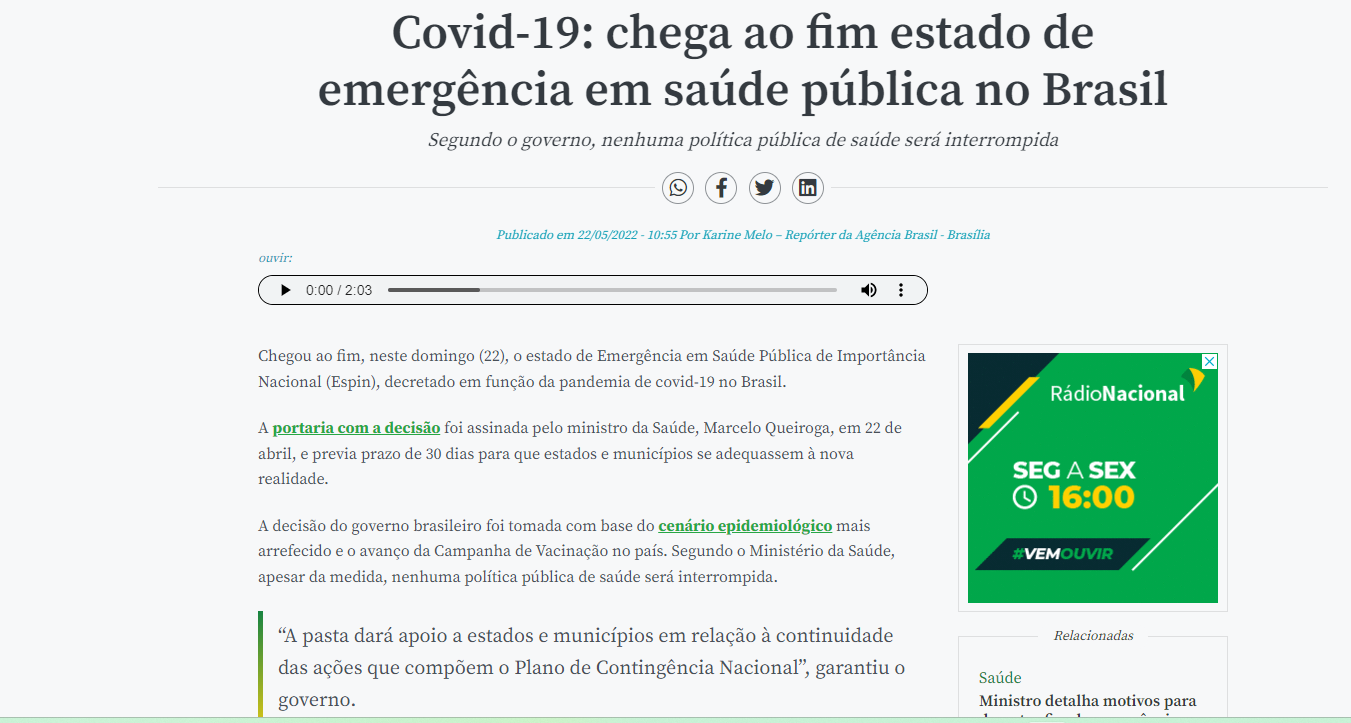


In [ ]:
# Criando a coluna "Covid"
dados=dados.assign(Covid='xxx')
inicio_pandemia= pd.to_datetime('2020-03-15')
fim_pandemia=pd.to_datetime('2022-04-22')
for i in range(0,comp_dados):
    if dados['Data'][i]<inicio_pandemia:
        dados['Covid'][i]="Pré-Pandemia"
    elif dados['Data'][i]> fim_pandemia:
        dados['Covid'][i]="Pós-Pandemia"
    else:
        dados['Covid'][i]="Pandemia"
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-16          28962.02           264.88   
5            Sul 2023-07-15          36728.19           335.91   
11           Sul 2023-07-14          46205.62           422.59   
13           Sul 2023-07-13          52300.54           478.34   
19           Sul 2023-07-12          38335.54           350.61   
...          ...        ...               ...              ...   
27067   Nordeste 2005-01-05          11820.00            85.58   
27068   Nordeste 2005-01-04          11285.00            81.71   
27074   Nordeste 2005-01-03          10929.00            79.13   
27078   Nordeste 2005-01-02          10267.00            74.34   
27082   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     9244.14                  84.55  20459.24    18722.40   
5                    15880.94                 145.2

In [ ]:
# Exibindo as informações do DataFrame "final", incorporada a coluna "Covid"
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27084 entries, 1 to 27082
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              27084 non-null  object        
 1   Data                    27084 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        27084 non-null  float64       
 3   ENA_Bruta[%MLT]         27084 non-null  float64       
 4   ENA_Armazenavel[MWmed]  27084 non-null  float64       
 5   ENA_Armazenavel[%MLT]   27084 non-null  float64       
 6   EAR_max                 27084 non-null  float64       
 7   EAR[MWmes]              27084 non-null  float64       
 8   EAR[%max]               27084 non-null  float64       
 9   Carga_Diaria[MWmed]     27084 non-null  float64       
 10  CMO_semanal[R$/MWh]     27084 non-null  float64       
 11  CMO_leve[R$/MWh]        27084 non-null  float64       
 12  CMO_media[R$/MWh]       27084 non-null  float6

Portanto, o dataframe "dados" possui todos os valores "não-nulos", sendo as colunas 'Subsistema' e 'Covid' qualitativas.

In [ ]:
# Verificando a distribuição das classes (Covid)
dados.groupby('Covid').size()

Covid
Pandemia         3076
Pré-Pandemia    22208
Pós-Pandemia     1800
dtype: int64

Numa etapa futura, que objetivará a predição do CMO, espera-se que o período da pandemia mereça algum tipo de tratamento especial, de modo a evitar vieses incorretos nas saídas dos modelos de Machine Learning, a ser tratado nos próximos Sprints.

In [ ]:
# Redefinindo os datasets por subsistema, incorporando a coluna "Covid"
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [ ]:
print(dados_SE)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-16          23074.89            89.98   
4        Sudeste 2023-07-15          23490.16            91.60   
10       Sudeste 2023-07-14          23547.38            91.82   
12       Sudeste 2023-07-13          22856.34            89.13   
18       Sudeste 2023-07-12          23746.20            92.60   
...          ...        ...               ...              ...   
27065    Sudeste 2005-01-05          45324.00            90.05   
27071    Sudeste 2005-01-04          44388.00            88.19   
27072    Sudeste 2005-01-03          43314.00            86.06   
27076    Sudeste 2005-01-02          43352.00            86.13   
27080    Sudeste 2005-01-01          43952.00            87.32   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]    EAR_max  EAR[MWmes]  \
0                    22561.49                  87.98  204615.33   174824.62   
4                    22991.98                  89

## Visualizações Unimodais

### Histogramas

In [ ]:
# Histograma para visualização dos dados de ENA_Bruta[MWmed];ENA_Bruta[%MLT]; EAR[MWmes]; EAR[%max]; Carga_Diaria[MWmed] e CMO_Semanal[R$/MWh]
# Carregando o estilo "seaborn-v0_8"
plt.style.use("seaborn-v0_8")

# Alterando alguns parâmetros gráficos
plt.rc("axes", facecolor="#fafafa", grid = True)
plt.rc("grid", color = "#f0f0f0")
plt.rc("axes", edgecolor="#cccccc", lw=0.1)

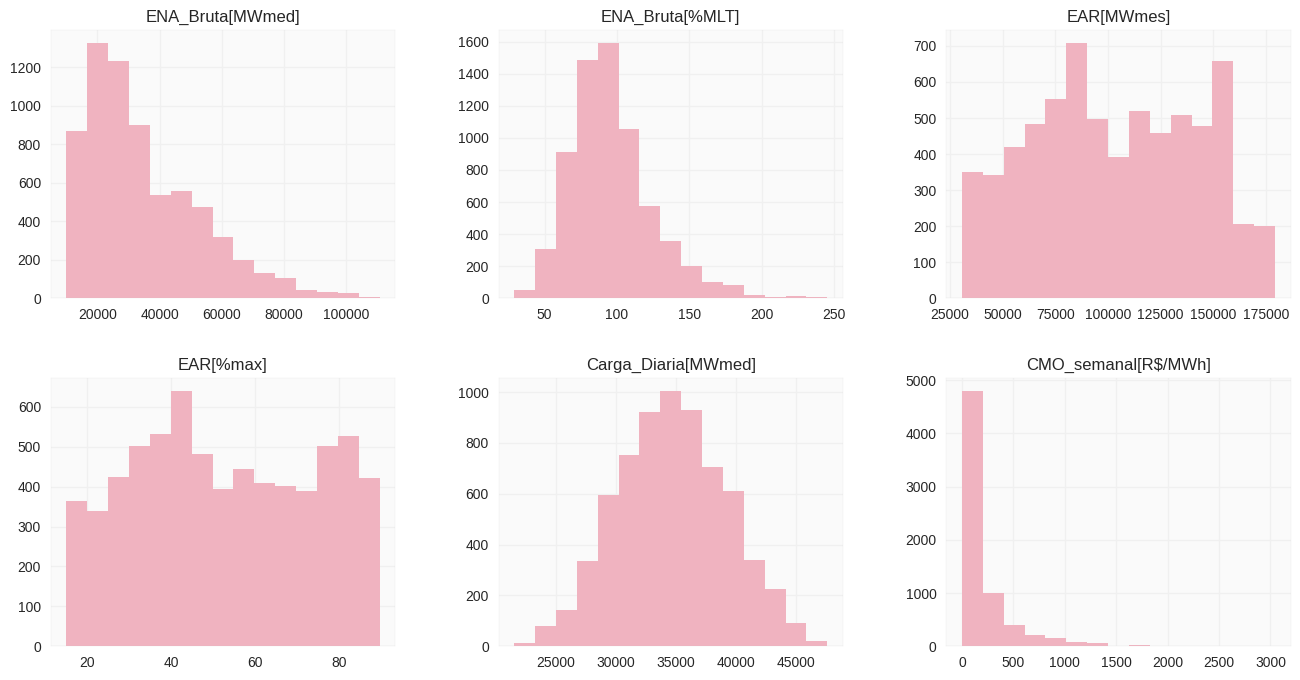

In [ ]:
# Histograma Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#F0b3c0")
plt.show()

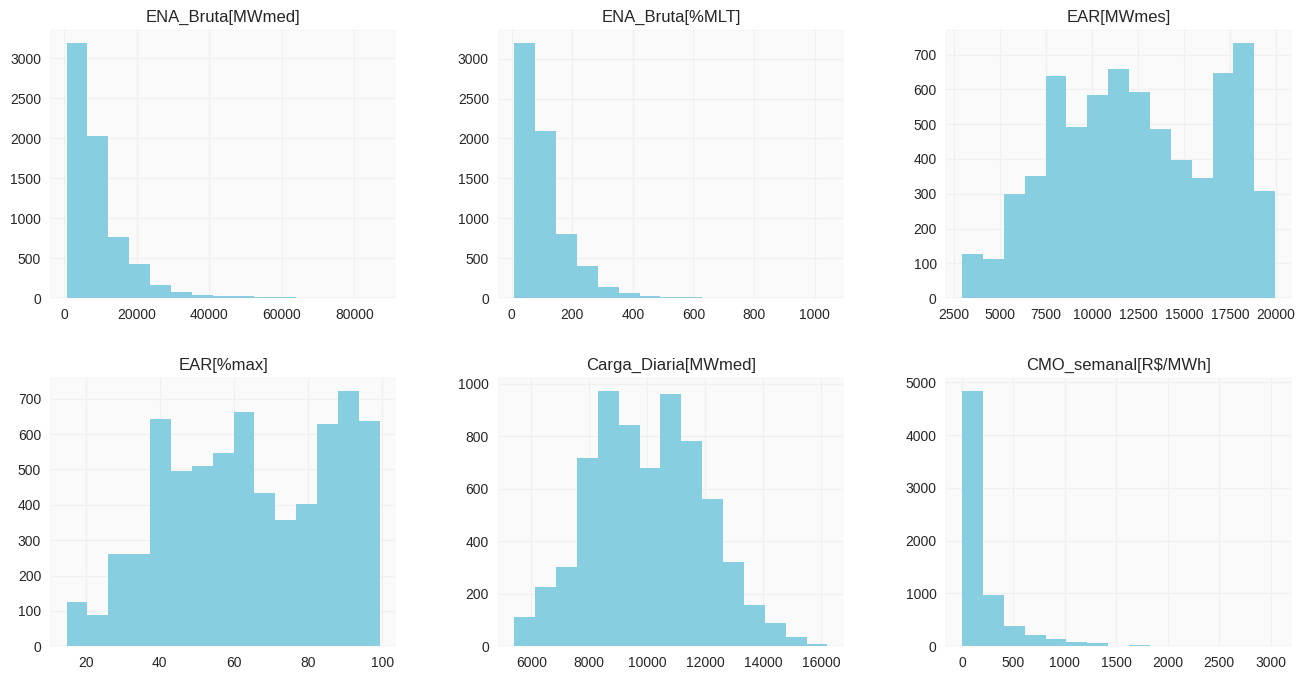

In [ ]:
# Histograma Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#87cee0")
plt.bar_label
plt.show()

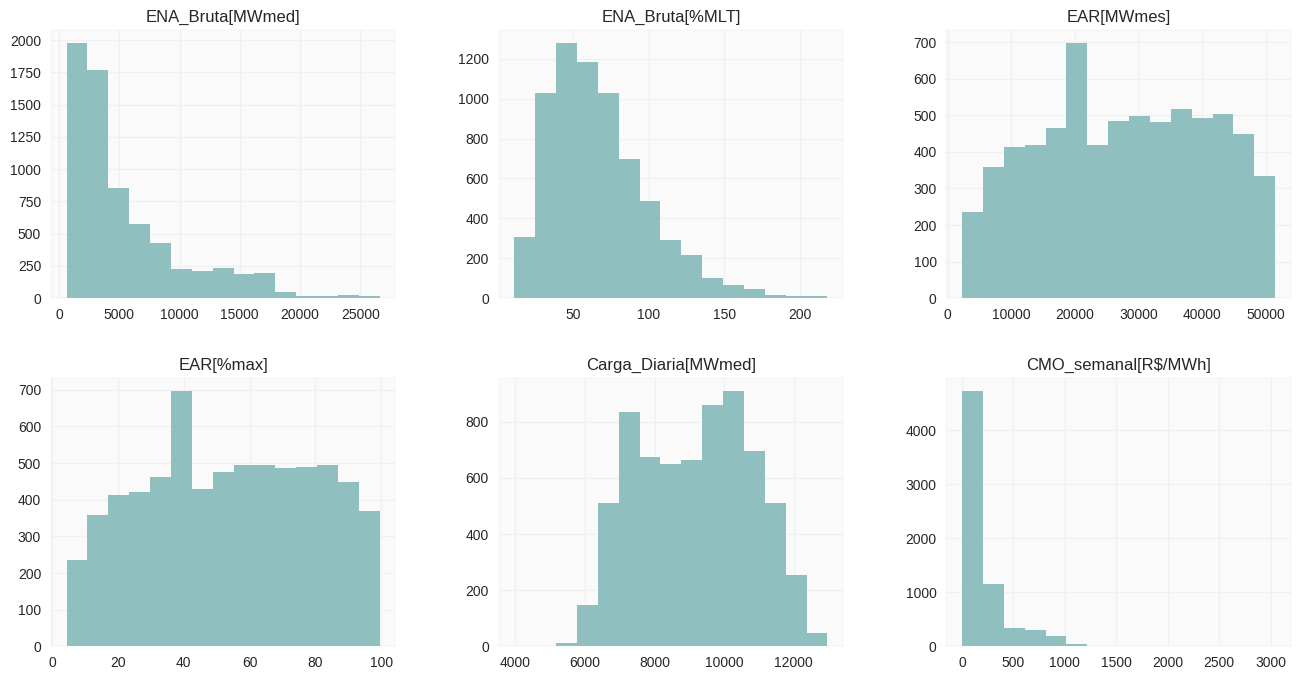

In [ ]:
# Histograma Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#8FBfbF")
plt.show()

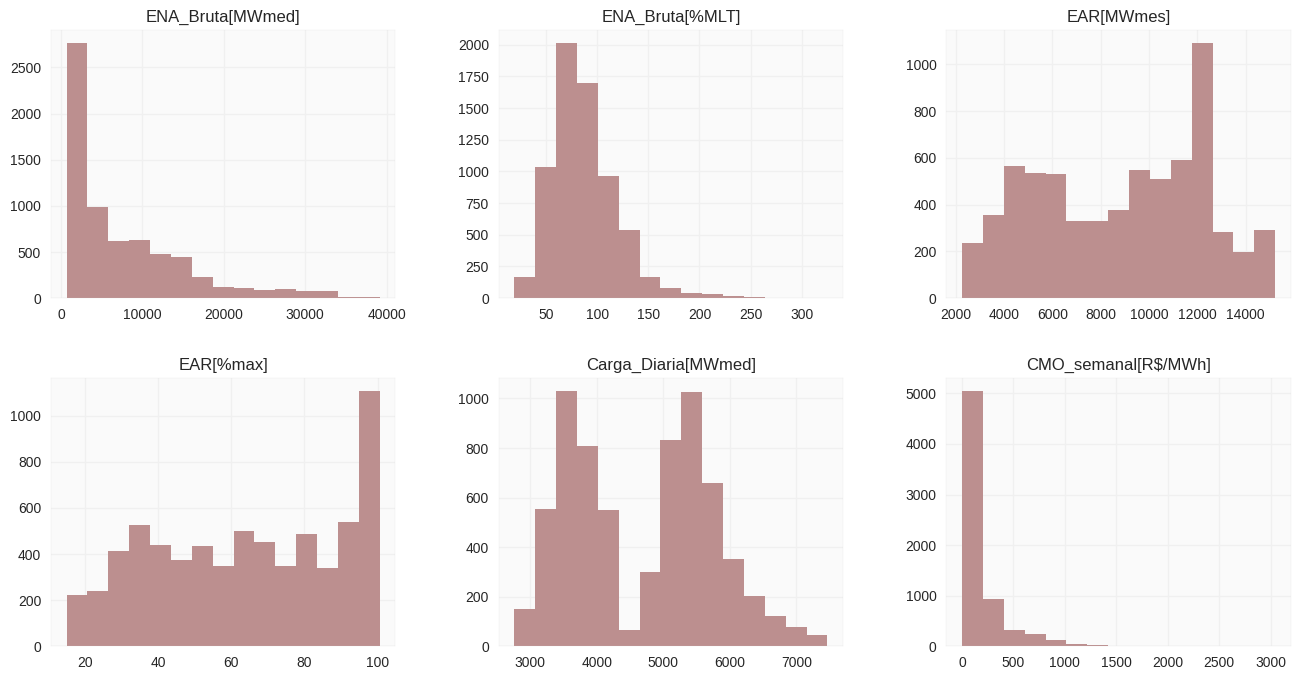

In [ ]:
# Histograma Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15, layout = (2,3), figsize = (16,8), color="#BC8F8F")
plt.show()



> Pela análise dos histogramas, para todos os subsistemas o CMO semanal apresenta assimetria positiva, indicando que a enorme maioria dos valores encontra-se abaixo dos 250 Reais/MWh, embora haja valores extremos, ultrapassando os 3000 R$/MWh, conforme visto nas tabelas com as estatísticas descritivas.


> Em relação ao comportamento da carga diária, para o Sudeste, aproxima-se bastante de uma distribuição normal. Chama a atenção a carga do Norte: provavelmente, esse comportamento "dividido em dois blocos bem definidos" se deve à entrada/saída de algum grande consumidor, que faça com que a ocorrência de valores entre 4 e 5 GWmed seja baixa.


> Em relação aos reservatórios, é interessante observar como, para o subsistema Nordeste, a maior frequência de EAR (%máx) no período está na faixa dos 40%. E que Sudeste e Sul também tiveram reservatórios próximos a esse patamar em um número expressivo de dias.



> Sobre a ENA em % da MLT, todos os subsistemas apresentam assimetria à direita. Para o Sudeste, a maior frequência é próxima dos 80-100% da MLT.









### Boxplot

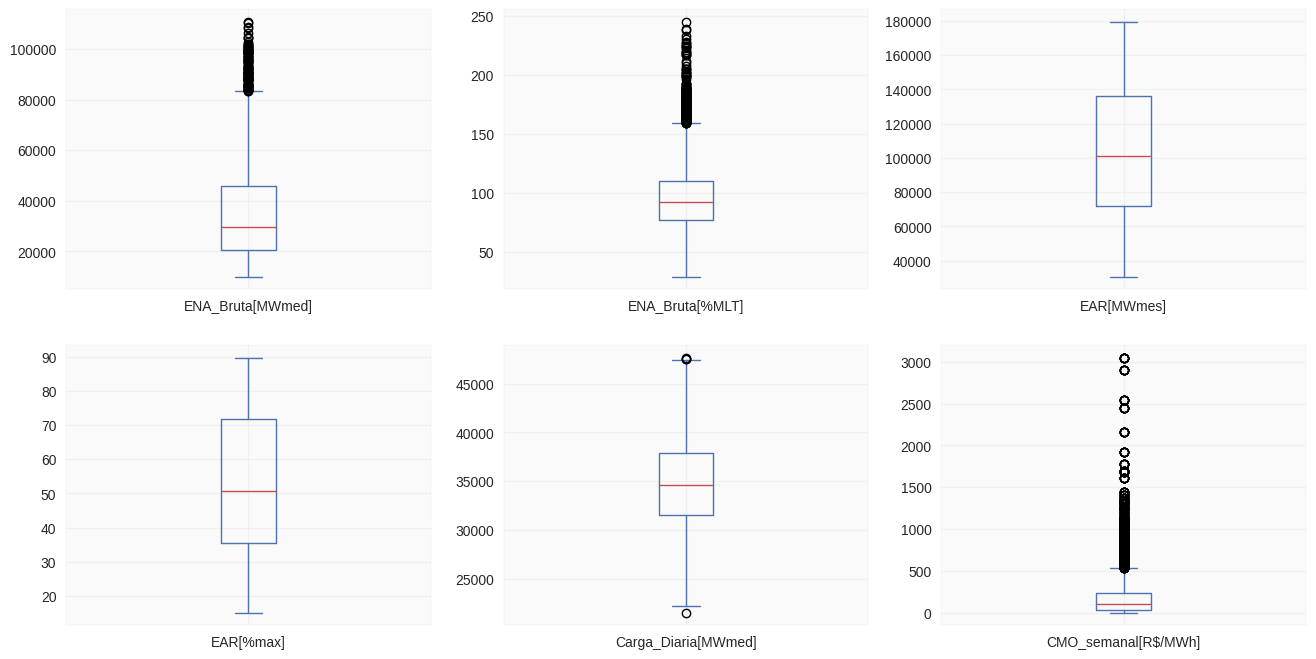

In [ ]:
# Boxplot Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

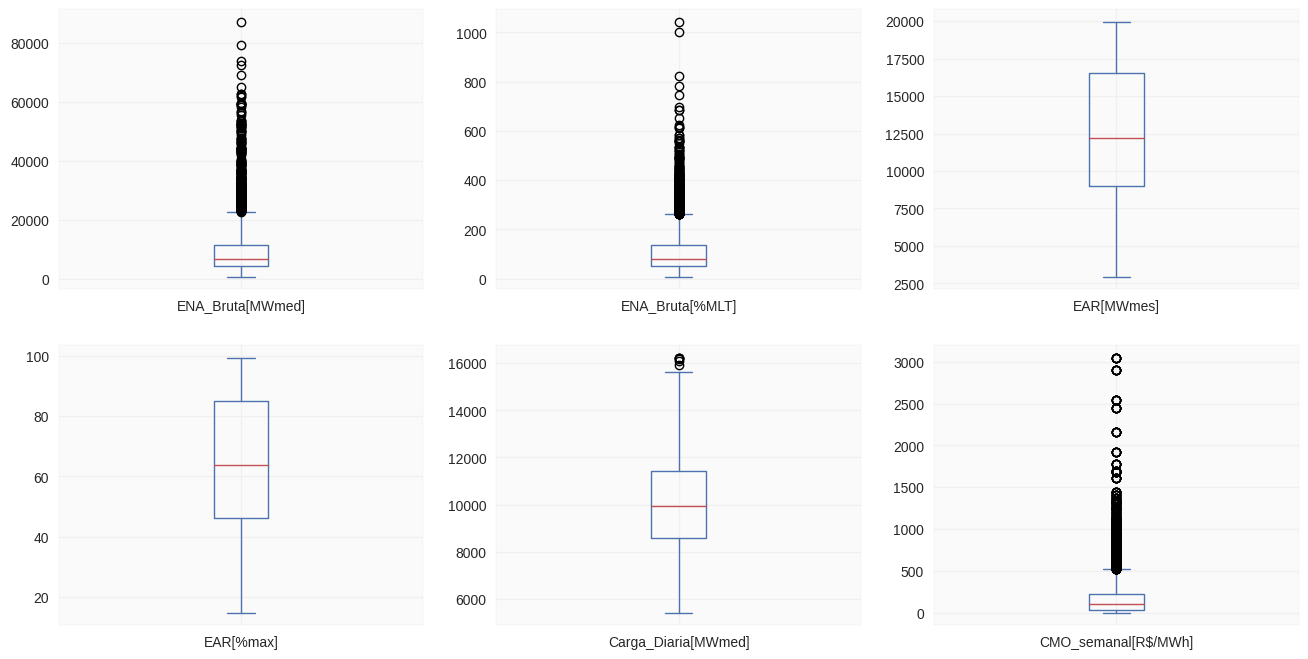

In [ ]:
# Boxplot Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

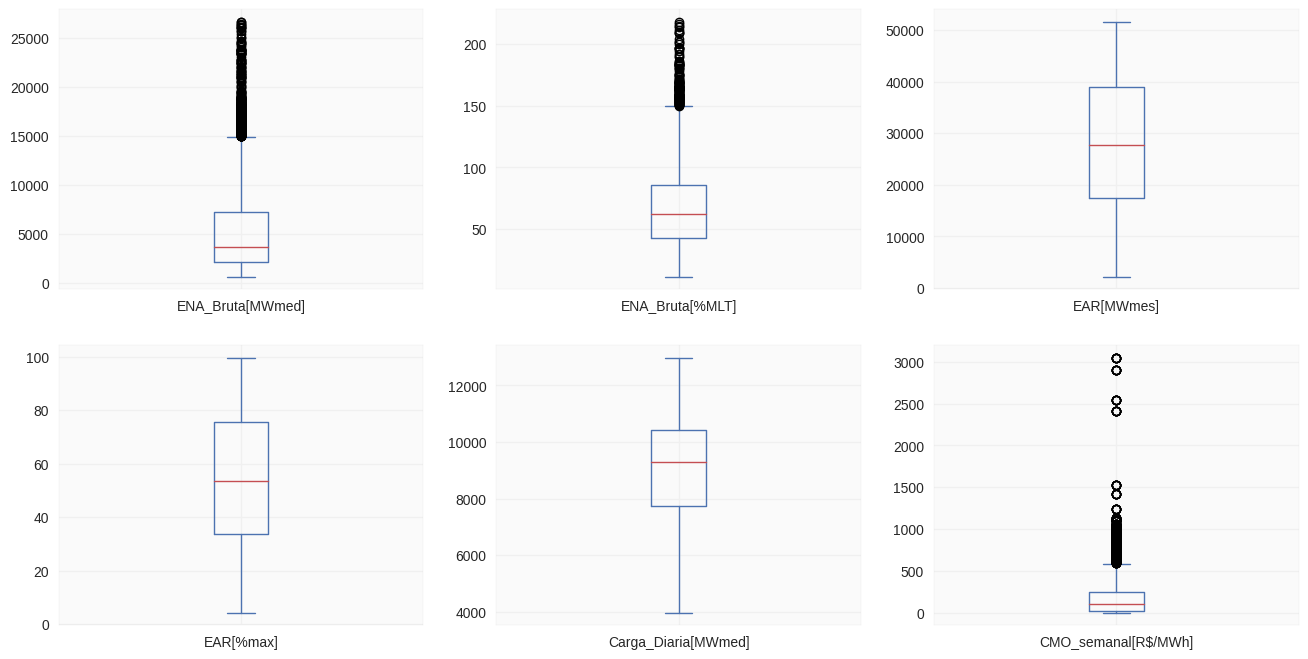

In [ ]:
# Boxplot Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

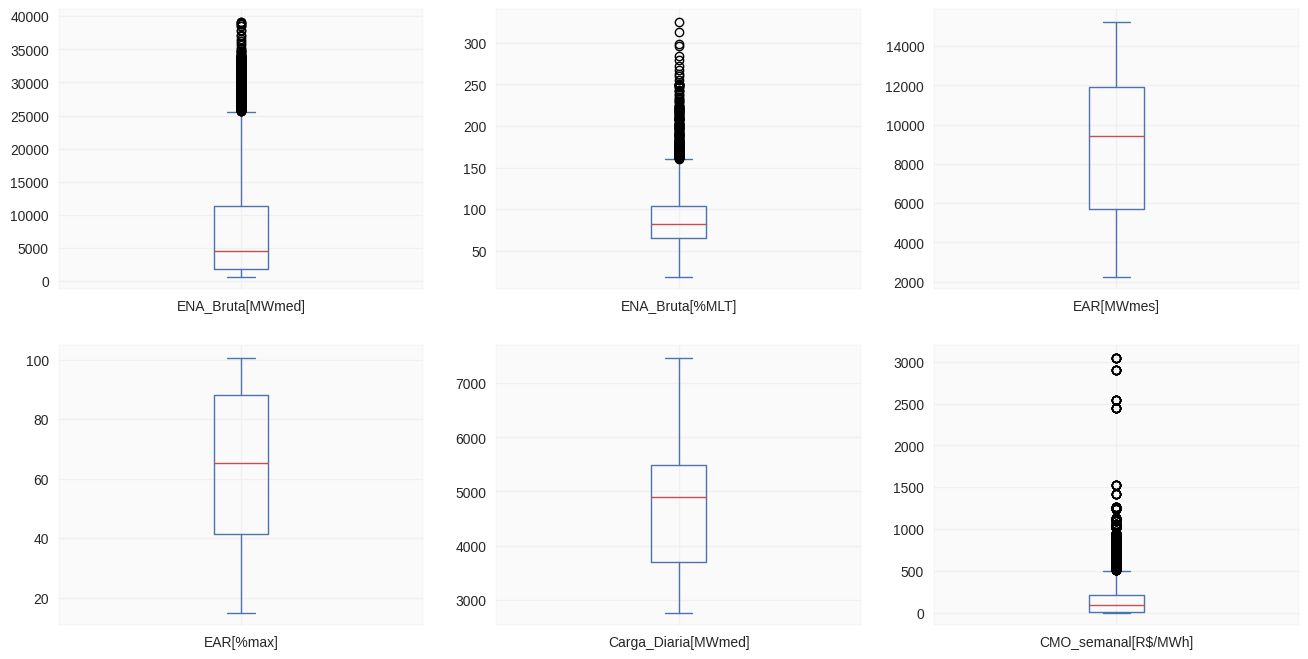

In [ ]:
# Boxplot Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()



> A análise dos gráficos boxplot corrobora as constatações do histograma. Nas plotagens, a linha vermelha representa a mediana (imune a outliers). Para todos os subsistemas, observa-se que, em relação à Energia Armazenada, todos os valores encontram-se dentro dos limites do boxplot (tanto em MWmes quanto em %máximo). Este fato pode ser depreendido do histograma, pelo qual é possível perceber que não há diferenças significativas nas distribuições de probabilidade dos reservatórios, considerando um mesmo subsistema. Fato semelhante ocorre para os gráficos de carga diária. Neste ponto, destaca-se o fato de que, para a região Norte, o valor de P50 (próximo aos 5 GWmed) está bem mais próximo do valor correspondente ao terceiro quartil (P75) do que do primeiro (P25). Isso indica uma distribuição elevada de carga na faixa dos 5 ao 5,5 GWmed no referido subsistema. Para o Sul e Sudeste, alguns poucos valores acima do limite superior do intervalo.

> Em relação à ENA, no entanto, para todos os subsistemas se observam bastante valores fora dos limites do boxplot, característica das distribuições com assimetria à direita. Como destaque, para o Sul, houve uma ocorrência de ENA superior aos 1000% da MLT o que, certamente, configura um evento extremamente atípico em termos meteorológicos/climatológicos.


> Por fim, em relação ao CMO, observa-se que em 50% da amostra, os valores são inferiores a 150 Reais/MWh para os 4 subsistemas. O P75 não chega aos 250 Reais/MWh e o limite da faixa gira em torno dos 500 Reais/MWh. Nas etapas de predição/prescrição, faz-se necessário, portanto, maior atenção aos valores fora do intervalo, provavelmente correspondentes a períodos de grave escassez hídrica, como foi o biênio 2020-2021, quando os baixos valores de ENA e EArm levaram ao CMO de mais de 3000 Reais/MWh.






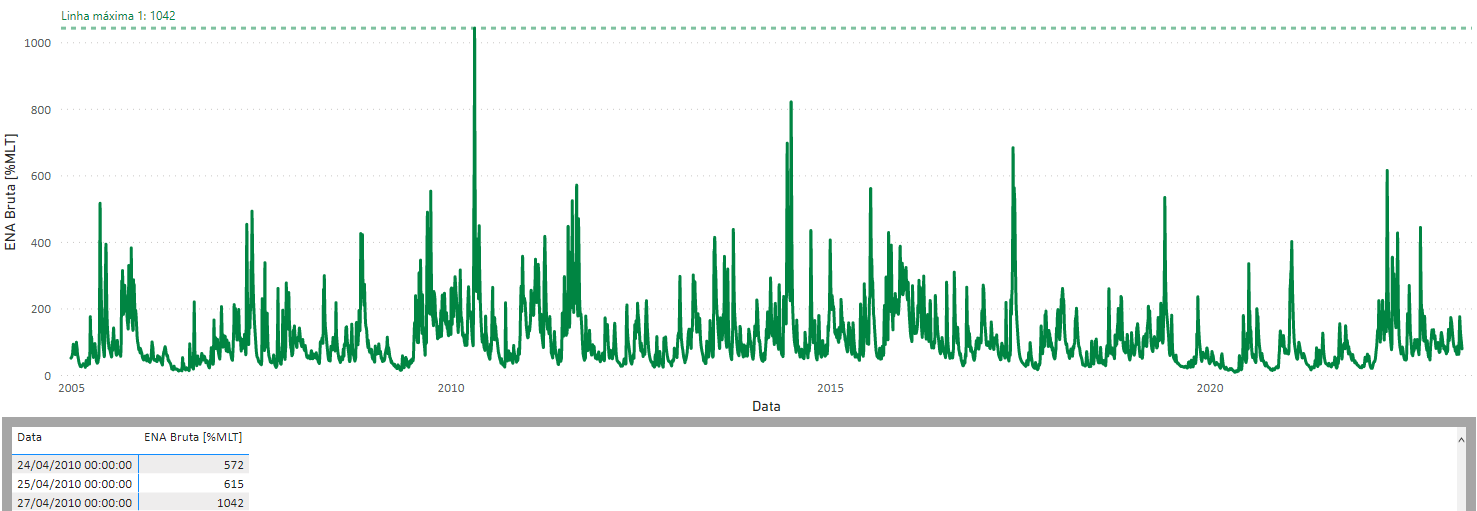
Data de ocorrência do evento de mais de 1000% da MLT na região Sul, correspondente a cerca de 60 GWmed (gráfico elaborado por meio do Power BI).

## Visualizações Multimodais

### Matriz de Correlação

<Axes: >

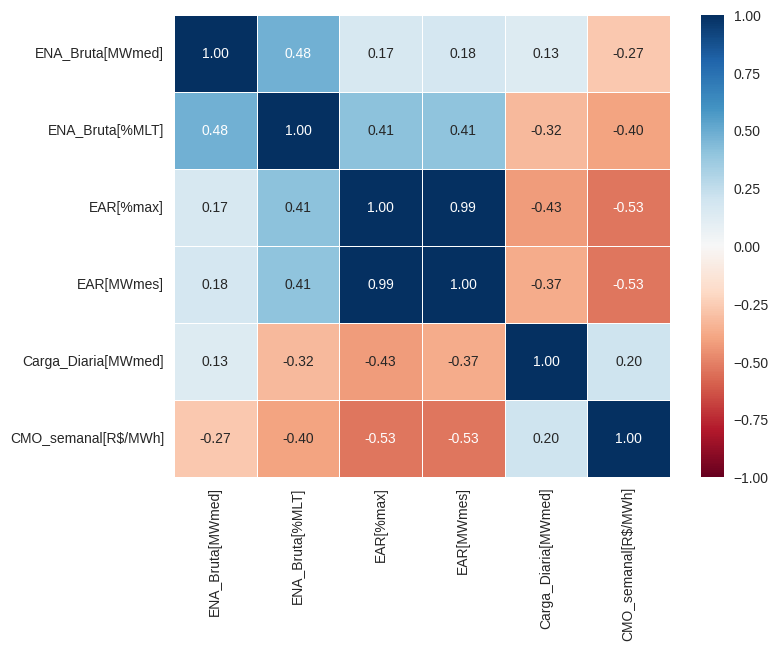

In [ ]:
# Matriz de Correlação para o Sudeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

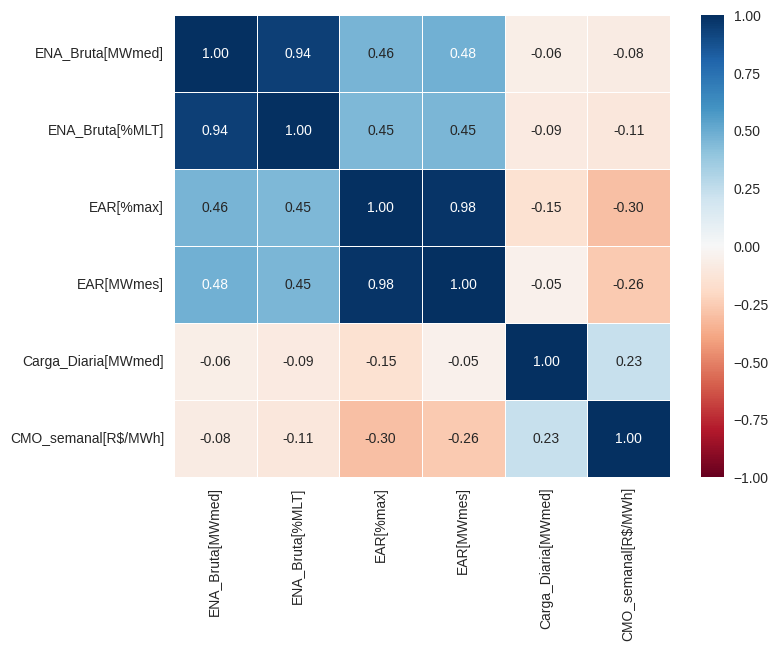

In [ ]:
# Matriz de Correlação para o Sul
plt.figure(figsize=(8,6))
sns.heatmap(dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

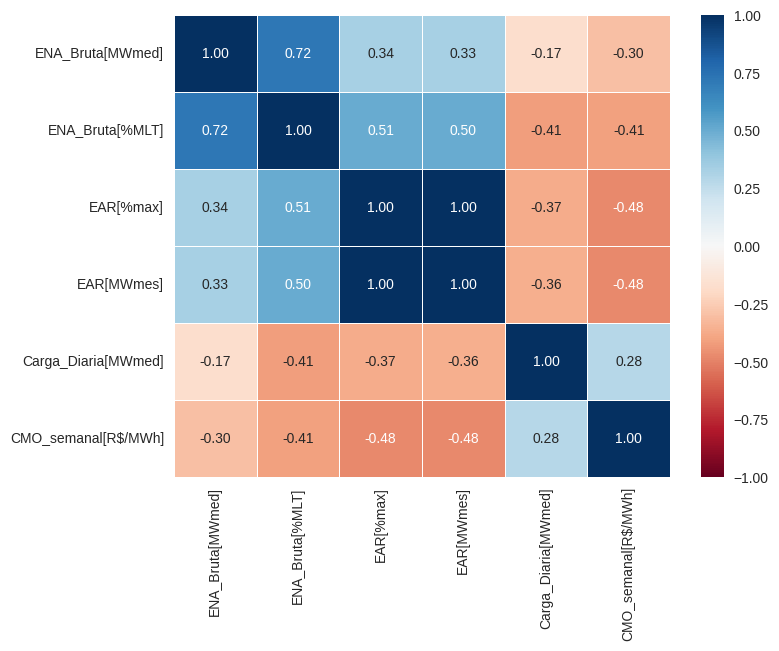

In [ ]:
# Matriz de Correlação para o Nordeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

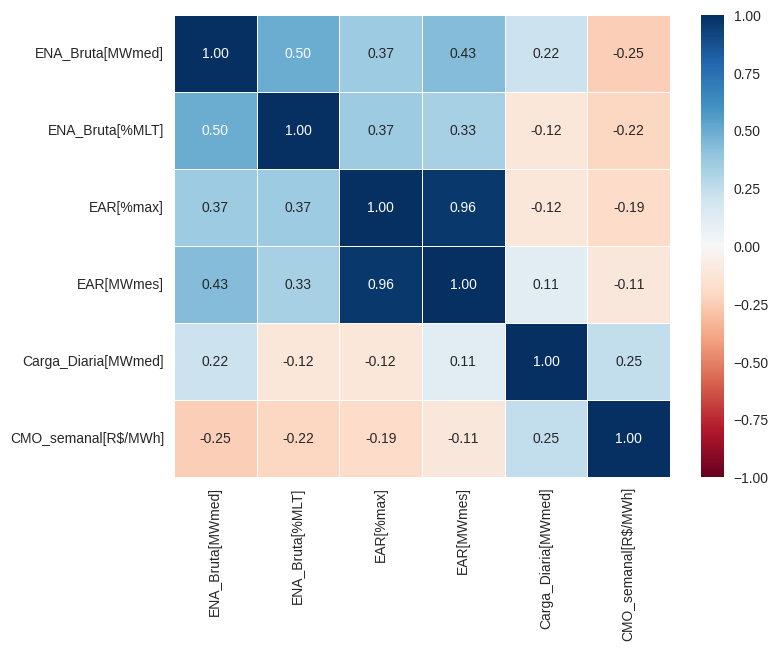

In [ ]:
# Matriz de Correlação para o Norte
plt.figure(figsize=(8,6))
sns.heatmap(dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

Conforme analisado anteriormente, considerando todo o horizonte de dados disponível (2005-dias atuais), é possível identificar uma correlação moderada (negativa) do CMO com a Energia Armazenada (em % do volume útil) e com a Energia Natural Afluente (em % da MLT) principalmente para o Sudeste e o Nordeste, que são os subsistemas com maior volume máximo de reservatórios do SIN. Para a carga, a correlação é positiva moderada, em todos os subsistemas, conforme esperado "intuitivamente". É possível constatar ainda que ENA (%MLT) e EArm (%máx) se correlacionam positivamente. Esse comportamento faz sentido, uma vez que na ocorrência de chuvas (e, consequentemente, de elevação da ENA) espera-se que os reservatórios (EArm) também se encham. As políticas operativas, no entanto, podem acabar levando a maiores ou menores deplecionamentos dos reservatórios das usinas hidroelétricas, por fora dos modelos, a depender da conjuntura hidrológica e do balanço energético do Sistema Interligado Nacional.

### Scatter Plot

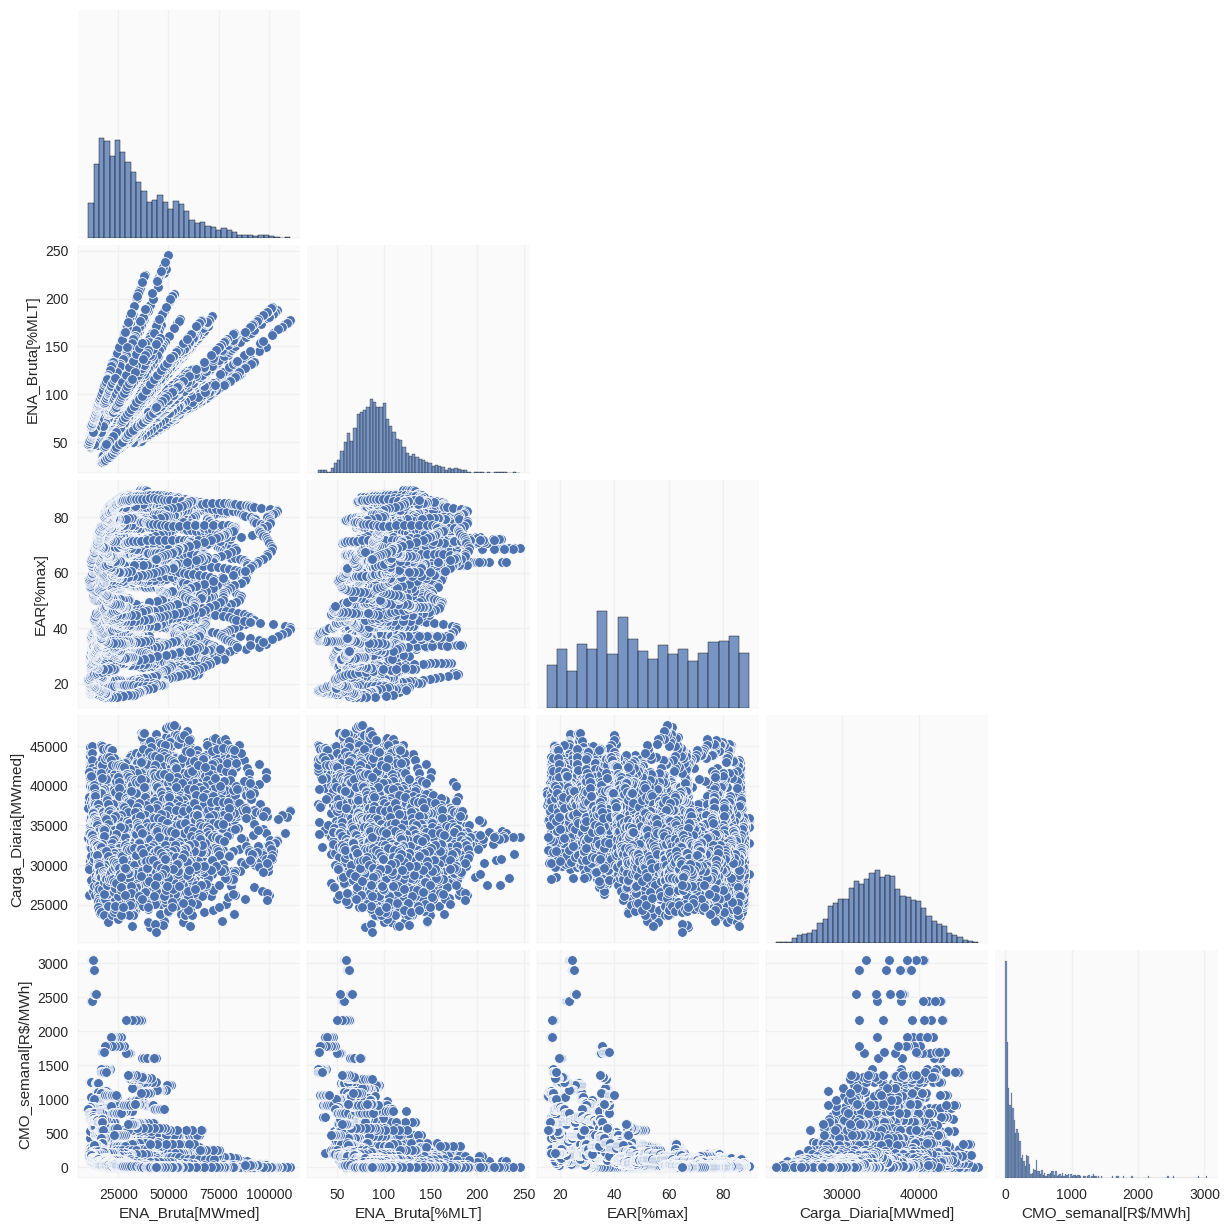

In [ ]:
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
# Scatter Plot com Seaborn - Sudeste
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']], corner=True)

Pela avaliação do scatter-plot, podemos observar como os maiores valores de CMO semanal ocorrem para valores de ENA Bruta inferiores a 75% da MLT e para reservatórios abaixo dos 40% do volume útil no Sudeste. É possível observar também que o CMO de 0 R$/MWh nunca ocorreu em casos de ENA diária inferior a 50% da MLT no Sudeste. Um outro destaque é o fato de os maiores valores de CMO não terem ocorrido para valores mínimos de ENA em % da MLT (e sim próximo aos 60%), mas, para ENAs muito baixas em termos absolutos (MWmed). Isto nos leva a crer que esses Custos muito elevados se deram em algum mês de MLT mais baixa (ou seja, de valores históricos de chuva mais baixos, pela sazonalidade/climatologia. Provavelmente, entre junho e novembro, meses do chamado "período seco"). Além disso, para reservatórios superiores a 50%-55%, o CMO não ultrapassou os 500 Reais/MWh que, como vimos no Boxplot, é o limite superior do mesmo. Em relação à carga, à exceção de valores outlier de CMO, o comportamento da curva Carga x CMO parece ter uma tendência de distribuição normal, para a qual valores mais elevados de CMO ocorrem em cargas intermediárias, entre 30 e 40 GWmed. Esse comportamento não é intuitivo, a princípio. Porém, como pode ser visto no gráfico de ENA Bruta (MWmed) x Carga, os maiores valores de ENA ocorreram para cargas de aproximadamente 35 GWmed e isso poderia explicar o comportamento do CMO (embora essa relação ENA x Carga possa ser uma coincidência em função da pandemia - menor carga e El Niño - condições climáticas - menor ENA). Para trabalhos futuros, fazem-se necessárias avaliações mais detalhadas a respeito.

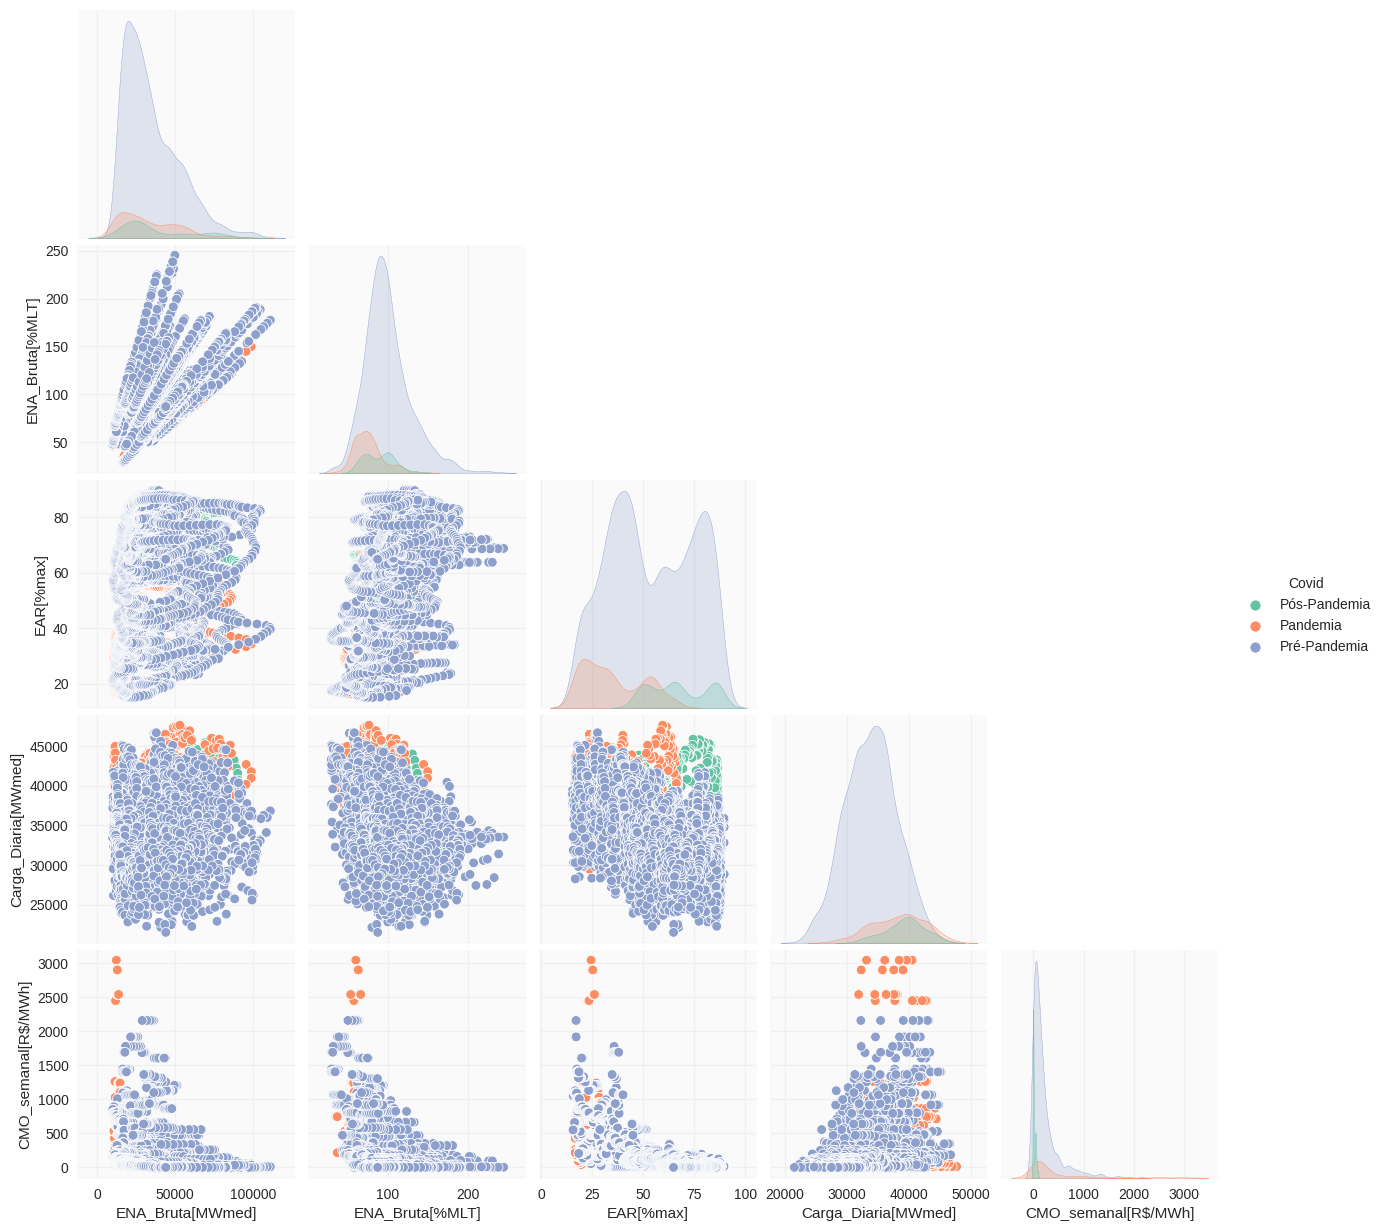

In [ ]:
# Scatter Plot considerando a variável qualitativa referente à pandemia de Covid-19
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','Covid']], hue = "Covid", height = 2.5, corner=True, palette="Set2")

A principal interferência da pandemia de Covid-19 nas grandezas avaliadas diz respeito à carga. Embora, coincidentemente (mas sem nenhum tipo de relação causal), os valores de ENA (em MWmed e em % da MLT) tenham tido uma distribuição mais assimétrica à direita no período da pandemia do que no período anterior a ela. É necessário, em análises futuras (e no treinamento dos modelos de ML) cautela neste aspecto, para que os algoritmos não indiquem correlações indevidas entre a pandemia e a ENA. Em relação à carga, durante a pandemia (e no pós), o que enxergamos é um deslocamento da curva para uma assimetria mais à esquerda. Para análises futuras, é interessante avaliar os anos imediatamente anteriores à pandemia (talvez encurtar o horizonte, neste caso, por exemplo), para tentar entender melhor os efeitos. Além disso, no durante e pós-pandemia observa-se um desvio-padrão maior (da carga) em comparação aos anos prévios. Sobre a correlação com o CMO, observamos que os maiores valores de CMO registrados ocorreram durante a pandemia, mesmo para cargas intermediárias que, fora da pandemia, levaram o custo no máximo a 70% dos 3000 Reais/MWh). E este fato provavelmente se explica pelos valores mais severos de ENA e EArm no intervalo de 2020 a 2022.

## Avaliações Temporais no Power BI

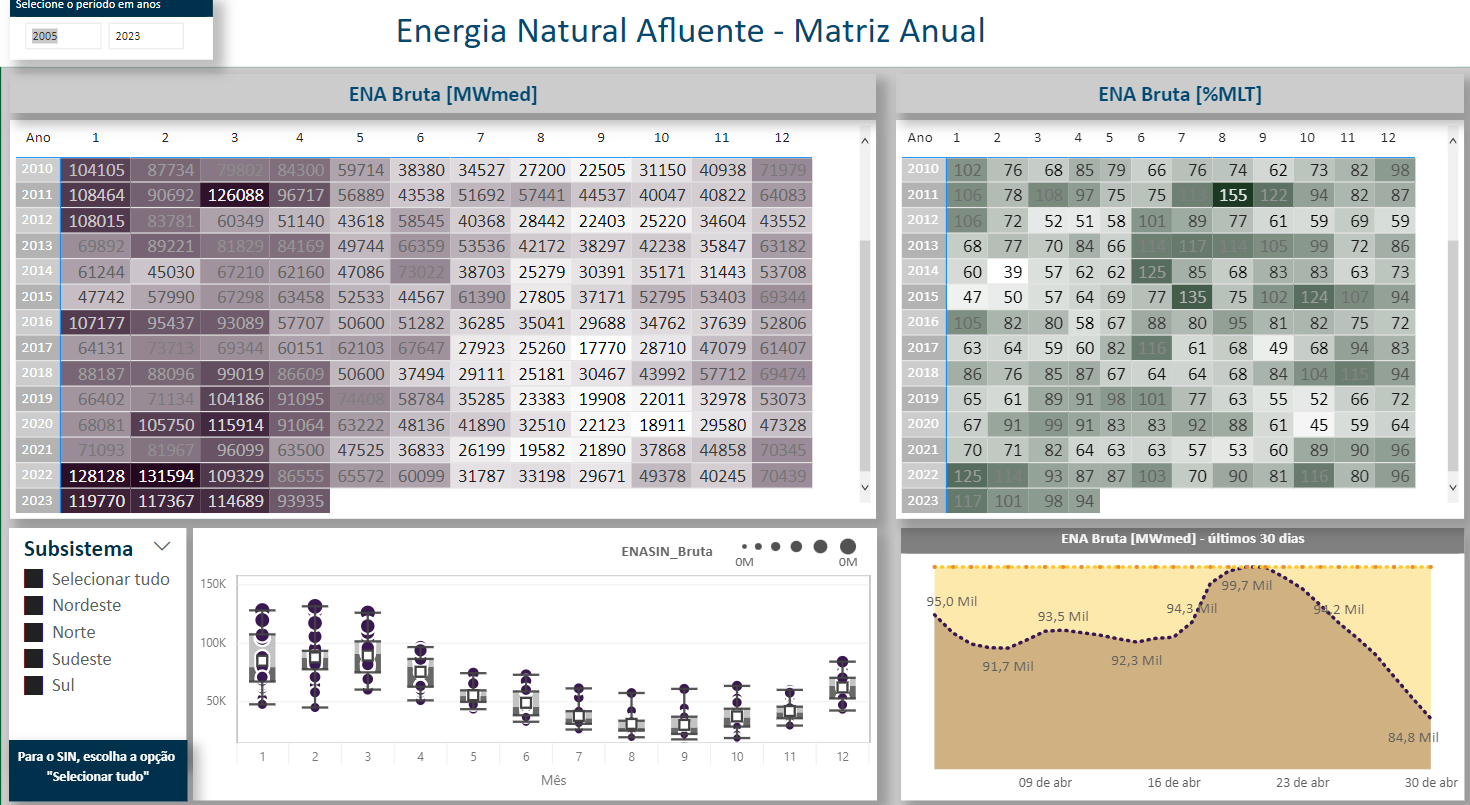

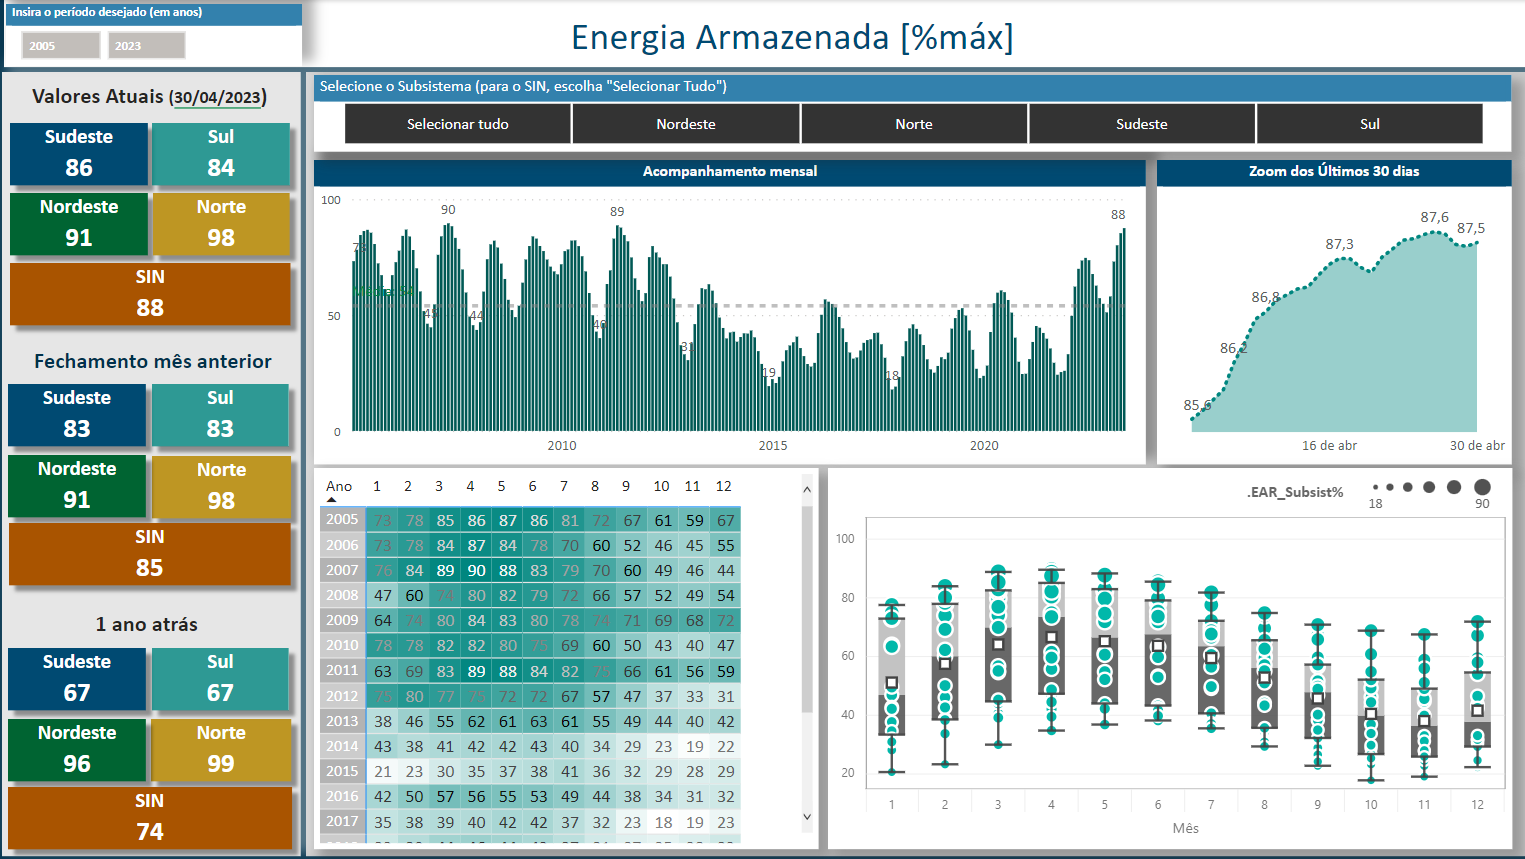

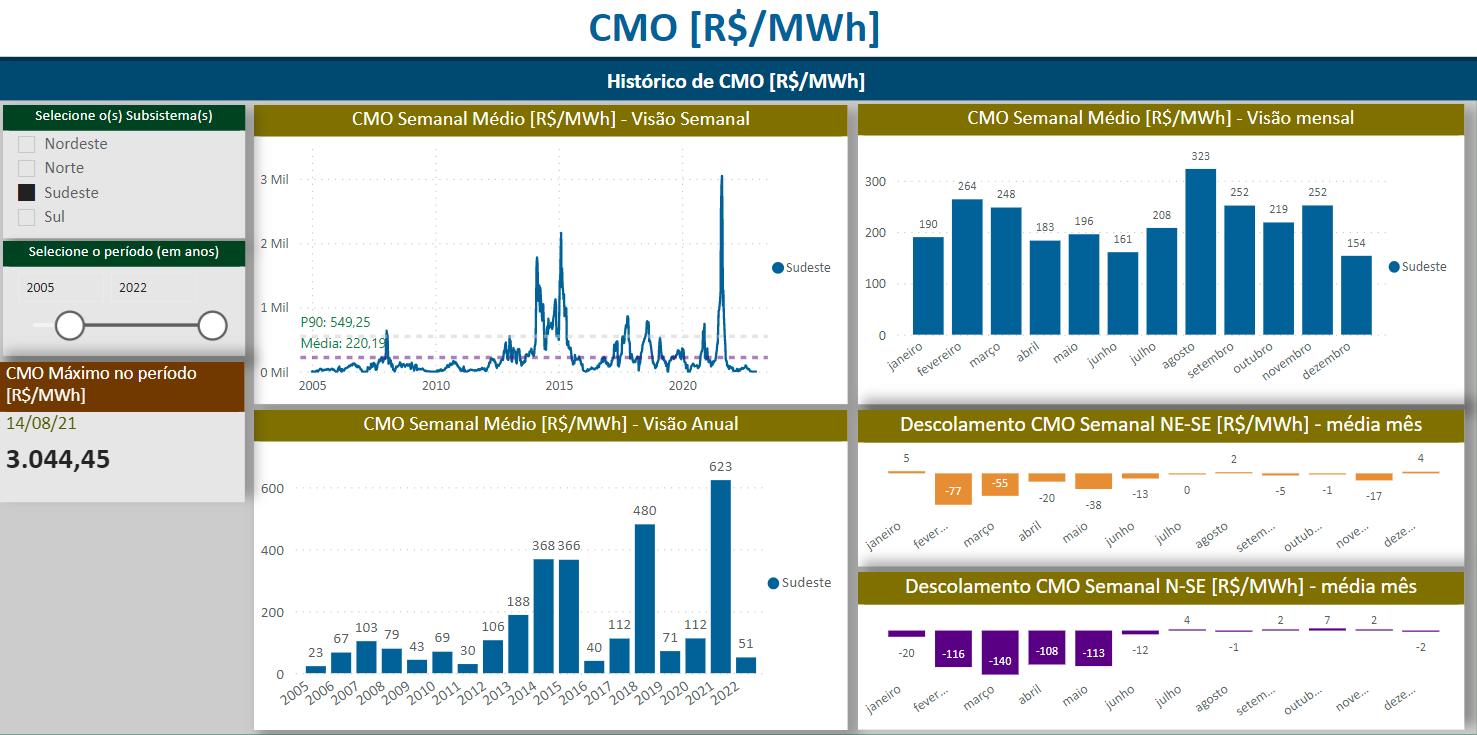

Os dados obtidos a partir da Área de Dados Abertos do ONS foram importados no Power BI (via Power Query) e, em seguida, foram gerados os dashboard acima. Pelas visualizações, pode-se concluir, por exemplo, que: desde 2011, o mês de abril não registrava ENA (% da MLT) tão alta. Além disso, pelo boxplot de ENA é possível identificar a sazonalidade do período chuvoso/seco no Brasil, de modo que dezembro a abril são os meses de maior mediana (período úmido). Em relação ao histórico recente, observa-se uma queda de mais de 10 GWmed de ENA no SIN entre o final de março e o final de abril o que é, de certa forma, esperado pela climatologia dos referidos meses. Apesar da redução da ENA (em termos absolutos) os reservatórios do SIN sofreram uma elevação no último mês. Quando comparados ao mesmo período de 2022 (30/04/23 vs 30/04/22), a crescente é muito expressiva, principalmente no Sul e no Sudeste. Podemos perceber que o enchimento/deplecionamento dos reservatórios tem um comportamento cíclico ao longo de um ano e que, desde 2011, não observávamos condições tão favoráveis de energia armazenada quanto atualmente. Em relação ao CMO médio no decorrer dos anos, observa-se que, de fato, 2011 teve valores baixíssimos do custo de operação médio. Também é possível observar que em 2021, quando as ENAs ficaram muito baixas, o preço médio anual foi o maior do histórico e que basta um ano favorável ou desfavorável em termos de chuva para alterar a tendência de CMO do ano anterior. Em relação aos valores médios nos meses, observa-se que agosto (mês de menor MLT no Sudeste) é o de maior CMO médio, ao passo que dezembro (início do período úmido), o de menor. Em relação aos valores por subsistema, observa-se que nos meses chuvosos, dentro do horizonte analisado, em geral o CMO do Nordeste e do Norte foi menor que o do Sudeste. Este aspecto está diretamente relacionado à capacidade de fluxo de energia entre os subsistemas e, considerando ampliações e reforços na transmissão, pode não ser mais replicável daqui em diante. Este aspecto não está explícito pelos dados do presente trabalho mas, em etapas futuras, faz-se pertinente a inclusão.


# **Seção IV: Pré-Processamento de Dados - Parte 2**


> Ao longo das seções/etapas anteriores, já realizamos várias atividades de pré-processamento de dados, de modo a deixar nosso DataFrame mais "enxuto", menos "redundante" e mais adequado para aplicação de Modelos de Machine Learning. Neste momento, iremos reduzir ainda mais a dimensionalidade e realizar algumas transformações numéricas.



## Redução da Dimensionalidade

In [ ]:
# Reduzindo a dimensionalidade do dataset dados, excluindo as colunas de CMO por patamar
dados=dados[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_SE=dados_SE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_S=dados_S[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_NE=dados_NE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_N=dados_N[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]',]]

# Avaliando as 20 primeiras linhas do dataset dados
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-07-16        Sul          28962.02           264.88   
5  2023-07-15        Sul          36728.19           335.91   
11 2023-07-14        Sul          46205.62           422.59   
13 2023-07-13        Sul          52300.54           478.34   
19 2023-07-12        Sul          38335.54           350.61   
21 2023-07-11        Sul          22496.02           205.75   
25 2023-07-10        Sul          14429.43           131.97   
29 2023-07-09        Sul          12108.33           110.74   
35 2023-07-08        Sul           8608.78            78.74   
37 2023-07-07        Sul           4990.26            45.64   
41 2023-07-06        Sul           4762.62            43.56   
45 2023-07-05        Sul           4915.62            44.96   
50 2023-07-04        Sul           5309.10            48.56   
53 2023-07-03        Sul           5678.98            51.94   
57 2023-07-02        Sul           6164.08            56.38   
61 2023-07-01        Sul           6748.79            61.72   
67 2023-06-30        Sul           7627.10            73.02   
69 2023-06-29        Sul           8900.53            85.21   
73 2023-06-28        Sul          10477.56           100.31   
77 2023-06-27        Sul          12606.83           120.69   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                  9244.14                  84.55  20459.24      91.51   
5                 15880.94                 145.25  20459.24      91.36   
11                21595.28                 197.51  20459.24      91.10   
13                10606.34                  97.00  20459.24      90.59   
19                 7774.86                  71.11  20459.24      90.13   
21                 9618.34                  87.97  20459.24      88.99   
25                10312.65                  94.32  20459.24      87.90   
29                 9373.17                  85.73  20459.24      87.42   
35                 7948.01                  72.69  20459.24      86.75   
37                 4933.46                  45.12  20459.24      86.48   
41                 4704.66                  43.03  20459.24      87.46   
45                 4783.86                  43.75  20459.24      87.92   
50                 5202.90                  47.59  20459.24      88.00   
53                 5619.60                  51.40  20459.24      87.93   
57                 5990.25                  54.79  20459.24      88.38   
61                 6685.17                  61.14  20459.24      88.44   
67                 7525.60                  72.05  20459.24      88.34   
69                 8105.35                  77.60  20459.24      88.69   
73                 7770.75                  74.39  20459.24      88.92   
77                 8777.64                  84.03  20459.24      88.76   

    EAR[MWmes]  Carga_Diaria[MWmed]         Covid  CMO_semanal[R$/MWh]  
1     18722.40              8588.72  Pós-Pandemia                  0.0  
5     18691.03             10013.12  Pós-Pandemia                  0.0  
11    18638.33             11964.35  Pós-Pandemia                  0.0  
13    18534.92             12162.46  Pós-Pandemia                  0.0  
19    18440.34             12879.68  Pós-Pandemia                  0.0  
21    18205.68             12615.74  Pós-Pandemia                  0.0  
25    17983.21             12422.03  Pós-Pandemia                  0.0  
29    17884.51              9591.29  Pós-Pandemia                  0.0  
35    17748.65             11085.51  Pós-Pandemia                  0.0  
37    17693.62             13166.78  Pós-Pandemia                  0.0  
41    17893.71             12946.72  Pós-Pandemia                  0.0  
45    17988.29             12879.67  Pós-Pandemia                  0.0  
50    18003.37             12745.53  Pós-Pandemia                  0.0  
53    17989.88             12326.18  Pós-Pandemia                  0.0  
57    18081.52              9695.05

In [ ]:
# Confirmando novamente a ausência de dados faltantes
dados.isnull().sum()

Data                      0
Subsistema                0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[%max]                 0
EAR[MWmes]                0
Carga_Diaria[MWmed]       0
Covid                     0
CMO_semanal[R$/MWh]       0
dtype: int64

In [ ]:
# Exibindo as dimensões de cada dataset
print("SIN:")
print(dados.shape)
print("Sudeste:")
print(dados_SE.shape)
print("Sul:")
print(dados_S.shape)
print("Nordeste:")
print(dados_NE.shape)
print("Norte:")
print(dados_N.shape)

SIN:
(27084, 12)
Sudeste:
(6771, 12)
Sul:
(6771, 12)
Nordeste:
(6771, 12)
Norte:
(6771, 12)


## Preparação para os Algoritmos de ML

A Normalização e a padronização são técnicas frequentemente aplicadas na etapa de preparação dos dados, com o objetivo de colocá-los em um intervalo de valores comuns. Não são técnicas obrigatórias para todos os algoritmos de Machine Learning mas podem impactar na acurácia do modelo a ser utilizado.

Alterando os dados da coluna 'Covid' de qualitativos (categóricos) para codificação ordinal, de modo que "Pré-Pandemia"=0; "Pandemia"=1 e "Pós-Pandemia"=2

In [ ]:
# Armazenando os datasets com a coluna 'Covid' original
dados_pandemia=dados
dados_pandemia_SE=dados_SE
dados_pandemia_S=dados_S
dados_pandemia_NE=dados_NE
dados_pandemia_N=dados_N

In [ ]:
# Aplicando Ordinal Encoding
dados['Covid']=dados['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_SE['Covid']=dados_SE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_S['Covid']=dados_S['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_NE['Covid']=dados_NE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_N['Covid']=dados_N['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-07-16        Sul          28962.02           264.88   
5  2023-07-15        Sul          36728.19           335.91   
11 2023-07-14        Sul          46205.62           422.59   
13 2023-07-13        Sul          52300.54           478.34   
19 2023-07-12        Sul          38335.54           350.61   
21 2023-07-11        Sul          22496.02           205.75   
25 2023-07-10        Sul          14429.43           131.97   
29 2023-07-09        Sul          12108.33           110.74   
35 2023-07-08        Sul           8608.78            78.74   
37 2023-07-07        Sul           4990.26            45.64   
41 2023-07-06        Sul           4762.62            43.56   
45 2023-07-05        Sul           4915.62            44.96   
50 2023-07-04        Sul           5309.10            48.56   
53 2023-07-03        Sul           5678.98            51.94   
57 2023-07-02        Sul           6164.08            56.38   
61 2023-07-01        Sul           6748.79            61.72   
67 2023-06-30        Sul           7627.10            73.02   
69 2023-06-29        Sul           8900.53            85.21   
73 2023-06-28        Sul          10477.56           100.31   
77 2023-06-27        Sul          12606.83           120.69   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                  9244.14                  84.55  20459.24      91.51   
5                 15880.94                 145.25  20459.24      91.36   
11                21595.28                 197.51  20459.24      91.10   
13                10606.34                  97.00  20459.24      90.59   
19                 7774.86                  71.11  20459.24      90.13   
21                 9618.34                  87.97  20459.24      88.99   
25                10312.65                  94.32  20459.24      87.90   
29                 9373.17                  85.73  20459.24      87.42   
35                 7948.01                  72.69  20459.24      86.75   
37                 4933.46                  45.12  20459.24      86.48   
41                 4704.66                  43.03  20459.24      87.46   
45                 4783.86                  43.75  20459.24      87.92   
50                 5202.90                  47.59  20459.24      88.00   
53                 5619.60                  51.40  20459.24      87.93   
57                 5990.25                  54.79  20459.24      88.38   
61                 6685.17                  61.14  20459.24      88.44   
67                 7525.60                  72.05  20459.24      88.34   
69                 8105.35                  77.60  20459.24      88.69   
73                 7770.75                  74.39  20459.24      88.92   
77                 8777.64                  84.03  20459.24      88.76   

    EAR[MWmes]  Carga_Diaria[MWmed]  Covid  CMO_semanal[R$/MWh]  
1     18722.40              8588.72      2                  0.0  
5     18691.03             10013.12      2                  0.0  
11    18638.33             11964.35      2                  0.0  
13    18534.92             12162.46      2                  0.0  
19    18440.34             12879.68      2                  0.0  
21    18205.68             12615.74      2                  0.0  
25    17983.21             12422.03      2                  0.0  
29    17884.51              9591.29      2                  0.0  
35    17748.65             11085.51      2                  0.0  
37    17693.62             13166.78      2                  0.0  
41    17893.71             12946.72      2                  0.0  
45    17988.29             12879.67      2                  0.0  
50    18003.37             12745.53      2                  0.0  
53    17989.88             12326.18      2                  0.0  
57    18081.52              9695.05      2                  0.0  
61    18094.06             10884.16      2                  0.0  
67    18

In [ ]:
# Adicionando uma coluna referente ao dia da semana correspondente à data

dados=dados.assign(Dia_da_semana=1)
dados=dados.assign(Numero_da_semana=100000)
dados=dados.sort_values('Data',ascending=True)
for i in range(0,comp_dados):
    dados['Dia_da_semana'][i]=dados['Data'][i].weekday() #Por esta lógica, as segundas recebem o índice 0  e os domingos, 6
# Para retratar semanas operativas, que vão do sábado à sexta da semana seguinte, é interessante que os sábados correspondam ao 0, domingos ao 1...sexta-feira corresponda a 6:
    if dados['Dia_da_semana'][i]<5:   #(de segunda a sexta-feira)
       dados['Dia_da_semana'][i]=dados['Dia_da_semana'][i]+2
       dados['Numero_da_semana'][i]=dados['Data'][i].week
    else:    #(sábado e domingo)
       dados['Dia_da_semana'][i]=dados['Dia_da_semana'][i]-5
       dados['Numero_da_semana'][i]=dados['Data'][i].week+1
print(dados)


            Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
27080 2005-01-01    Sudeste          43952.00            87.32   
27083 2005-01-01      Norte           4157.00            50.75   
27081 2005-01-01        Sul           2812.00            50.65   
27082 2005-01-01   Nordeste          10222.00            74.01   
27077 2005-01-02        Sul           2814.00            50.69   
...          ...        ...               ...              ...   
6     2023-07-15   Nordeste           2090.45            55.38   
2     2023-07-16   Nordeste           2074.39            55.69   
3     2023-07-16      Norte           4114.63            78.21   
0     2023-07-16    Sudeste          23074.89            89.98   
1     2023-07-16        Sul          28962.02           264.88   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]    EAR_max  EAR[%max]  \
27080                40017.00                  79.51  177852.00      64.78   
27083                 4157.00                  50.7

A variável que pretendemos predizer é o CMO Semanal Médio. Para tal, dividiremos nosso dataset por cada um dos subsistemas, considerando os subconjuntos de treino, teste e validação.

Por se tratar de uma variável numérica, contínua, utilizaremos algoritmos de Machine Learning destinados a problemas de regressão.

In [ ]:
# Separando cada dataset (por subsistema) em componentes de "entrada" e "saída"
# A variável de interesse é o CMO Semanal Médio [R$/MWh]
# A data não será considerada

# SIN
array=dados.values
X= array[:,1:11] # atributos
y=array[:,11] # classe (target)
# Sudeste
X_SE= dados_SE.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_SE=dados_SE.values[:,11]  # classe (target)
# Sul
X_S= dados_S.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_S=dados_S.values[:,11]  # classe (target)
# Nordeste
X_NE= dados_NE.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_NE=dados_NE.values[:,11]  # classe (target)
# Norte
X_N= dados_N.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_N=dados_N.values[:,11]  # classe (target)

Neste momento, realizaremos a análise apenas para o subsistema Sudeste, uma vez que responde por mais de 60% da carga do Sistema Interligado Nacional e por mais de 70% da capacidade de armazenamento. Portanto, será realizada etapa de normalização e padronização dos dados quantitativos do dataset dados_SE

In [ ]:
# Dividindo os dados nos subconjuntos de treino e teste (25% dos dados serão utilizados para teste)
X_train,X_test,y_train,y_test= train_test_split(X_SE, y_SE, test_size=0.25, random_state=7)

# Criando os folds para validação cruzada
num_particoes = 30 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 30 folds

### Normalização dos Dados

In [ ]:
# Normalizando os dados
rescaledX_norm_train = MinMaxScaler().fit_transform(X_train)
rescaledX_norm_test = MinMaxScaler().fit_transform(X_test)

# Exibindo os dados transformados
print("Dados de Treino Originais: \n\n", X_train)
print("\nDados de Treino Normalizados (não inclui a coluna class): \n\n", rescaledX_norm_train)

print("Dados de Teste Originais: \n\n", X_test)
print("\nDados de Teste Normalizados (não inclui a coluna class): \n\n", rescaledX_norm_test)

Dados de Treino Originais: 

 [[34069.0 130.8 30258.0 ... 130410.0 35309.56 0]
 [44917.0 91.69 41815.0 ... 145433.0 31354.51 0]
 [23288.0 85.57 23164.0 ... 150021.0 29760.78 0]
 ...
 [57732.46 87.74 54977.06 ... 81704.36 46369.54 1]
 [72768.34 105.57 67262.8 ... 94823.34 42913.54 0]
 [22382.0 83.63 20570.0 ... 120938.0 32662.15 0]]

Dados de Treino Normalizados (não inclui a coluna class): 

 [[0.23809902 0.47057189 0.27744719 ... 0.67048469 0.52777479 0.        ]
 [0.34586347 0.28946515 0.42630088 ... 0.77164559 0.37625766 0.        ]
 [0.13100016 0.26112526 0.18607676 ... 0.80253996 0.3152022  0.        ]
 ...
 [0.47317273 0.27117388 0.59582767 ... 0.34251384 0.95148027 0.5       ]
 [0.62253974 0.35373929 0.75406749 ... 0.43085357 0.81908165 0.        ]
 [0.12199992 0.2521417  0.15266615 ... 0.60670276 0.42635307 0.        ]]
Dados de Teste Originais: 

 [[14608.0 85.97 14192.0 ... 135799.0 29691.79 0]
 [45407.0 111.6 35568.0 ... 174192.0 29709.41 0]
 [21612.0 126.14 21426.0 ... 1352

### Padronização dos Dados

In [ ]:
# Padronizando os dados
rescaledX_padr_train = StandardScaler().fit_transform(X_train)
rescaledX_padr_test = StandardScaler().fit_transform(X_test)

# Exibindo os dados transformados
print("Dados de Treino Originais: \n\n", X_train)
print("\nDados de Treino Padronizados (não inclui a coluna class): \n\n", rescaledX_padr_train)

print("Dados de Teste Originais: \n\n", X_test)
print("\nDados de Teste Padronizados (não inclui a coluna class): \n\n", rescaledX_padr_test)

Dados de Treino Originais: 

 [[34069.0 130.8 30258.0 ... 130410.0 35309.56 0]
 [44917.0 91.69 41815.0 ... 145433.0 31354.51 0]
 [23288.0 85.57 23164.0 ... 150021.0 29760.78 0]
 ...
 [57732.46 87.74 54977.06 ... 81704.36 46369.54 1]
 [72768.34 105.57 67262.8 ... 94823.34 42913.54 0]
 [22382.0 83.63 20570.0 ... 120938.0 32662.15 0]]

Dados de Treino Padronizados (não inclui a coluna class): 

 [[-0.03414075  1.22810155 -0.08221066 ...  0.70204524  0.1207332
  -0.43465703]
 [ 0.56543806 -0.139515    0.70531021 ...  1.08775161 -0.75137789
  -0.43465703]
 [-0.63001642 -0.35352199 -0.56561232 ...  1.20554571 -1.10280445
  -0.43465703]
 ...
 [ 1.27376017 -0.27764043  1.6022036  ... -0.54844239  2.5595219
   1.33676222]
 [ 2.10480692  0.34584725  2.43938251 ... -0.21162057  1.79745418
  -0.43465703]
 [-0.68009186 -0.42136081 -0.74237351 ...  0.45885741 -0.46303581
  -0.43465703]]
Dados de Teste Originais: 

 [[14608.0 85.97 14192.0 ... 135799.0 29691.79 0]
 [45407.0 111.6 35568.0 ... 174192.0

LR: MSE 68452.56 (28194.18) - RMSE 261.63
Ridge: MSE 68452.52 (28193.48) - RMSE 261.63
Lasso: MSE 68612.93 (28322.40) - RMSE 261.94
KNN: MSE 28237.83 (10471.07) - RMSE 168.04
CART: MSE 12394.33 (11307.69) - RMSE 111.33
SVM: MSE 93527.94 (37600.25) - RMSE 305.82


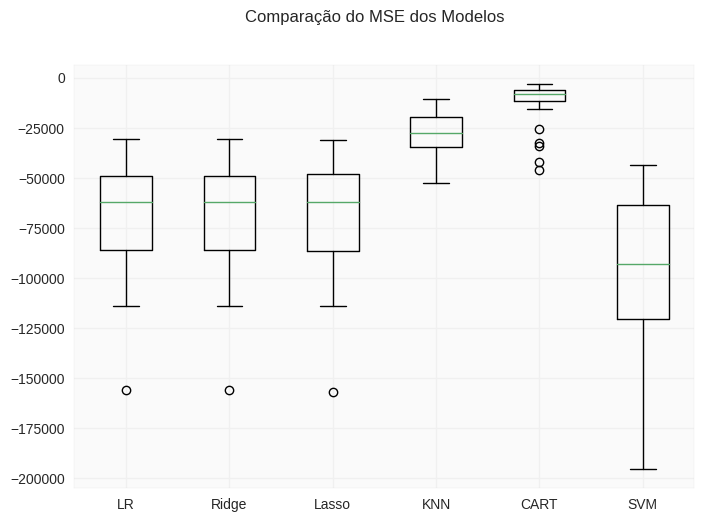

In [ ]:
# Modelagem

# Definindo uma semente global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


> Avaliando o boxplot de comparação dos valores de MSE e do RMSE (mais fácil de analisar, justamente por estar na mesma dimensão - R$/MWh - que a variável target) para cada um dos métodos de regressão elencados, observa-se que o algoritmo de Árvore de Decisão (CART) se mostra consideravelmente mais promissor que os demais para o problema de predição do Custo Marginal da Operação a partir de grandezas relevantes (Energia Natural Afluente, Energia Armazenada e Demanda Energética). Nesse caso, construiremos um novo modelo, treinado com toda a base de treino.




In [ ]:
# Criando um modelo com todo o conjunto de treino
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictions)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 7017.41
RMSE 83.77




> Quando ampliamos a avaliação do modelo de Árvore de Decisão para o conjunto de teste, observamos que o valor do RMSE permanece inferior ao dos demais métodos para o subconjunto de treino. Todavia, apesar de o modelo de Árvore de Decisão tenha se mostrado, numa primeira análise, melhor do que os demais, as métricas de erro (MSE e RMSE) ainda podem ser reduzidas. Para tal, podemos lançar mão de técnicas avançadas de Aprendizado Supervisionado, considerando a possibilidade de utilizarmos métodos "ensemble" e a seleção de features na tentativa de alcançarmos melhores predições.



# **Seção V: Técnicas Avançadas para Aprendizado Supervisionado**

## Modelagem e Inferência
O problema em voga necessita de modelos de regressão, uma vez que os resultados esperados (CMO Médio) são numéricos. Por este motivo, nesta seção buscaremos métodos ensemble voltados para problemas de Regressão. Testaremos os "mais populares": voting, bagging e boosting, com o objetivo de aprimorarmos a predição da variável target.

## Random Forest

> De acordo com a teoria da "sabedoria das multidões", as predições agregadas de um grupo de preditores tende a gerar melhores respostas do que o melhor preditor individual. Em Aprendizado Supervisionado, um dos métodos "ensemble" mais poderosos na atualidade consiste no treinamento de um grupo de decisores de uma árvore de decisão, cada um com um subconjunto aleatório diferente do conjunto de treinamento. São obtidas, então, as predições de todas as árvores individuais e, depois, a mais votada. Este agrupamento de árvores de decisão se chama "Random Forest" e será um dos métodos aplicados na próxima seção.
No Random Forest, algumas amostras dos dados de treino
(linhas do dataset) são selecionadas de maneira aleatória, sendo que as árvores criadas pelo algoritmo não conterão a totalidade dos dados utilizados na construção do modelo.



In [ ]:
# Criando um modelo com todo o conjunto de treino
model = RandomForestRegressor(min_samples_leaf=1, n_estimators=1000, random_state=0)
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictionsRF = model.predict(X_test)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictionsRF)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 6127.57
RMSE 78.28




> Conforme pode ser observado, aplicando-se o método da Floresta Aleatória com 1000 estimadores reduz o MSE e o RMSE em comparação ao método de Árvore de Decisão, inclusive quando estendemos a validação para o conjunto de teste. Como desdobramento, pode-se concluir, portanto, que o Random Forest está reduzindo o overfitting em comparação ao CART, visto que o erro na predição (como verificado para o subset de teste) diminui ao aplicarmos o RF.



## Histogram Gradient Boosting

Uma outra alternativa de técnica avançada de ML que pode ser aplicada, desdobrada do algoritmo de Árvore de Decisão, é o Histogram Gradient Boosting Regressor. As principais diferenças em relação ao Random Forest estão no fato de no HGBT as árvores serem treinadas sequencialmente, de forma que as árvores subsequentes corrijam os erros das anteriores. Além disso, as rodadas acontecem em uma ordem fixa e a sequência não pode ser alterada. O risco associado é que, se os dados forem muito ruidosos, as árvores no Gradient Boosting Regressor podem acabar modelando este ruído, contribuindo para o overfitting.



> A seguir, faremos uma análise alterando um dos principais hiperparâmetros do HGBT: o número máximo de iterações, mantendo a mesma profundidade máxima (5 nós). Podemos constatar que, para os valores testados, quanto maior o número máximo de iterações, menor o erro (com a desvantagem do aumento do tempo computacional, considerando um único núcleo para processamento. Este tempo pode diminuir ao utilizarmos computação paralela). Os testes serão realizados com validação cruzada, na tentativa de reduzirmos o overfitting.



In [ ]:
names2=[]
results2=[]
prediction = []
models2=[]
params_var=[]

models2.append(('HGBT_50', HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 50, early_stopping=False)))
models2.append(('HGBT_100', HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 100, early_stopping=False)))
models2.append(('HGBT_300', HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 300, early_stopping=False)))
models2.append(('HGBT_1000', HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 1000, early_stopping=False)))
models2.append(('HGBT_2000', HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 2000, early_stopping=False)))

# Avaliando um modelo por vez
for name, model in models2:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results2.append(cv_results)
    names2.append(name)
    # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
    msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
    print(msg)

HGBT_50: MSE 31067.09 (11063.33) - RMSE 176.26
HGBT_100: MSE 22804.46 (6732.87) - RMSE 151.01
HGBT_300: MSE 14602.55 (4540.96) - RMSE 120.84
HGBT_1000: MSE 9817.10 (3541.25) - RMSE 99.08
HGBT_2000: MSE 7967.21 (3056.27) - RMSE 89.26


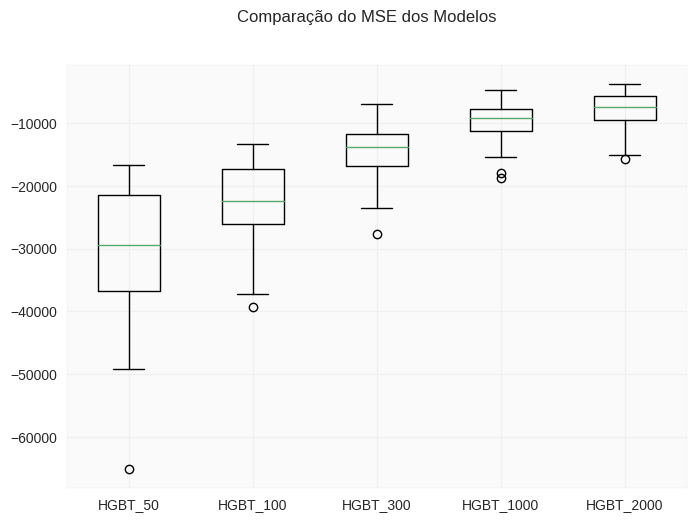

In [ ]:
# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()



> Podemos observar que, para o caso analisado, a partir de um determinado número máximo de iterações a diminuição do erro passa a ser mais lenta. Vamos estender a avaliação do modelo para o dataset de teste, considerando o caso com máx_iter = 2000 iterações, sem a validação cruzada.

In [ ]:
model = HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 2000, early_stopping=False)
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictionsHGBT = model.predict(X_test)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictionsHGBT)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 9489.66
RMSE 97.41



> Como pode-se observar, para a predição considerando o conjunto de teste, o modelo apresentou RMSE maior que o do Random Forest, melhor algoritmo até o presente momento.




## Avaliação conjunta de vários métodos ensemble: Linha de Base


> Agora que fizemos uma avaliação inicial de dois importantes métodos ensemble, vamos analisar a performance (segundo os critérios MSE e RMSE) de alguns outros modelos. Serão utilizados "parâmetros equivalentes", para tentarmos chegar a uma conclusão mais robusta a respeito dos mesmos.



Bagging: MSE 6137.99 (4025.38) - RMSE 78.35
RF: MSE 6435.02 (4060.76) - RMSE 80.22
ET: MSE 3291.37 (1892.39) - RMSE 57.37
Ada: MSE 87331.42 (14978.89) - RMSE 295.52
HGBT: MSE 6375.42 (3339.03) - RMSE 79.85
GB: MSE 20360.80 (7926.70) - RMSE 142.69
Voting: MSE 24084.84 (10272.96) - RMSE 155.19


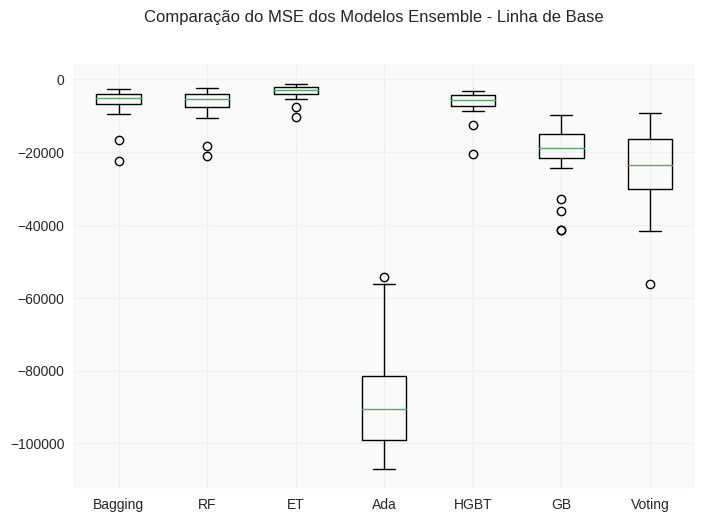

In [131]:
np.random.seed(0) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Definindo os parâmetros para o Bagging (usaremos Árvore de Decisão)
base = DecisionTreeRegressor()
num_trees = 200
max_features = 3 # o problema original não tem muitos atributos, mas vamos, ainda assim, definir a quantidade máxima de features para a predição

# Criando os modelos para o Voting (Árvore de Decisão; Support Vector Machine e KNN)
bases = []
model1 = DecisionTreeRegressor()
bases.append(('cart', model1))
model2 = SVR()
bases.append(('svm', model2))
model3 = KNeighborsRegressor()
bases.append(('KNN', model3))

# Criando os ensembles e adicionando-os à lista de modelos
models.append(('Bagging', BaggingRegressor(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostRegressor(n_estimators=num_trees)))
models.append(('HGBT', HistGradientBoostingRegressor(max_iter=num_trees)))
models.append(('GB', GradientBoostingRegressor(n_estimators=num_trees)))
models.append(('Voting', VotingRegressor(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos Ensemble - Linha de Base')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



> Pela avaliação da linha de base, o método de ExtraTrees (com 200 árvores), levou a erros significativamente menores que os demais (considerando o conjunto de testes). A seguir, vamos avaliar todos os modelos já elencados neste trabalho porém, considerando pipelines e os dados padronizados e normalizados, na tentativa de chegarmos, realmente, ao método que gere melhores erros possíveis.



In [ ]:
np.random.seed(0) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados (todos já avaliados em etapas anteriores deste código)

reg_lin=(('LR', LinearRegression(max_iter=200)))
ridge=(('Ridge', Ridge()))
lasso=(('Lasso', Lasso()))
knn=(('KNN', KNeighborsRegressor()))
cart=(('CART', DecisionTreeRegressor()))
svm=(('SVM', SVR()))
bagging = ('Bag', BaggingRegressor(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostRegressor(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingRegressor(n_estimators=num_trees))
hist_gradient_boosting = ('HGBT', HistGradientBoostingRegressor(n_estimators=num_trees))
voting = ('Voting', VotingRegressor(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler()) # Padronização
min_max_scaler = ('MinMaxScaler', MinMaxScaler()) # Normalização

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_lin])))
pipelines.append(('Ridge-orig', Pipeline([ridge])))
pipelines.append(('Lasso-orig', Pipeline([lasso])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('HGBT-orig', Pipeline([hist_gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_lin])))
pipelines.append(('Ridge-padr', Pipeline([standard_scaler, ridge])))
pipelines.append(('Lasso-padr', Pipeline([standard_scaler, lasso])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('HGBT-padr', Pipeline([standard_scaler, hist_gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_lin])))
pipelines.append(('Ridge-norm', Pipeline([min_max_scaler, ridge])))
pipelines.append(('Lasso-norm', Pipeline([min_max_scaler, lasso])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('HGBT-norm', Pipeline([min_max_scaler, hist_gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

In [ ]:
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=cv, error_score='raise')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

# **Seção VI: Conclusão**

O presente trabalho teve como objetivo a obtenção, tratamento e análise dos dados históricos de Energia Natural Afluente, Energia Armazenada, Demanda Elétrica e Custo Marginal da Operação, a partir dos dados diários por subsistema publicados pelo Operador Nacional do Sistema Elétrico. Puderam-se observar os comportamentos das referidas grandezas no período de 2005 a abril/2023, tanto ao longo do tempo, quanto em termos de distribuição (unimodal). Além disso, também foi possível avaliar as correlações entre as mesmas.

As etapas até aqui realizadas visam a, em um próximo momento, possibilitar a elaboração de algoritmos de aprendizagem de máquina no intuito de levar a predições/prescrições sobre expectativas de Custo Marginal da Operação frente a cenários futuros de ENA, EArm e Carga, considerando o histórico das mesmas e do próprio CMO.